In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Load Data

In [2]:
# Load Data
data_path = "data_slen_4_sec.pkl"

data = joblib.load(data_path)
x= data['x']  # EEG signals
y = data['y']  # BIS values
y_actual_for_plot = data['y']  # BIS valuesused in plot: pred vs actual
case_ids = data['c']  # Case IDs

print(f"x shape: {x.shape}, y shape: {y.shape}, case_ids shape: {case_ids.shape}")

# Handle NaN and Inf values in x and y
x[np.isnan(x)] = np.nanmean(x)  # Replace NaN with column mean
x[np.isinf(x)] = np.nanmean(x)  # Replace Inf/-Inf with column mean
y = y[~np.isnan(y)]  # Remove NaN values in y
y_actual_for_plot = y_actual_for_plot[~np.isnan(y)]
x = x[~np.isnan(y)]  # Align x with cleaned y

# Verify no NaN or Inf values remain
assert not np.isnan(x).any() and not np.isinf(x).any(), "Features contain NaN or Inf values"
assert not np.isnan(y).any() and not np.isinf(y).any(), "Target contains NaN or Inf values"


x_mean_data = np.mean(x, axis=0)
x_std_data = np.std(x, axis=0)

y_mean_data = np.mean(y)
y_std_data = np.std(y)




x shape: (463993, 512), y shape: (463993,), case_ids shape: (463993,)


# Normalize x and y

In [3]:
# Normalize x and y
x = (x - x_mean_data) / x_std_data
y = (y - y_mean_data) / y_std_data

# Train-Test Split (Ensuring no case ID mixing)

In [4]:
# Train-Test Split (Ensuring no case ID mixing)
unique_cases = np.unique(case_ids)
train_cases, test_cases = train_test_split(unique_cases, test_size=0.2, random_state=42)

train_idx = np.isin(case_ids, train_cases)
test_idx = np.isin(case_ids, test_cases)

x_train, x_test = x[train_idx], x[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

Train shape: (362760, 512), Test shape: (101233, 512)


# Convert to PyTorch tensors

In [5]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader
batch_size = 32
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=False)

# Early Stopping Class

In [6]:


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait before stopping after no improvement.
            min_delta (float): Minimum change in the monitored value to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif (self.best_loss - current_loss) < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0


# Evaluation Function

In [7]:
"""from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            # Handle input shape
            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(1)  # For CNNs
            output = model(batch_x)

            all_preds.extend(output.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute metrics
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / (all_targets + 1e-8))) * 100  # avoid div by zero

    print("📊 Evaluation Metrics:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    }
"""

'from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\ndef evaluate_model(model, dataloader, device):\n    model.eval()\n    all_preds = []\n    all_targets = []\n\n    with torch.no_grad():\n        for batch_x, batch_y in dataloader:\n            batch_x, batch_y = batch_x.to(device), batch_y.to(device)\n            batch_y = batch_y.squeeze()\n\n            # Handle input shape\n            if batch_x.ndim == 2:\n                batch_x = batch_x.unsqueeze(1)  # For CNNs\n            output = model(batch_x)\n\n            all_preds.extend(output.cpu().numpy())\n            all_targets.extend(batch_y.cpu().numpy())\n\n    all_preds = np.array(all_preds)\n    all_targets = np.array(all_targets)\n\n    # Compute metrics\n    mae = mean_absolute_error(all_targets, all_preds)\n    mse = mean_squared_error(all_targets, all_preds)\n    rmse = np.sqrt(mse)\n    r2 = r2_score(all_targets, all_preds)\n    mape = np.mean(np.abs((all_targets - all_

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            # Try reshaping as CNN-style input (batch, 1, 256)
            try:
                output = model(batch_x.unsqueeze(1))
            except Exception:
                try:
                    # Try reshaping as LSTM-style input (batch, 256, 1)
                    output = model(batch_x.unsqueeze(-1))
                except Exception as e:
                    print(f"⚠️ Failed to reshape input automatically: {e}")
                    output = model(batch_x)  # Last resort: try as-is

            all_preds.extend(output.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute metrics
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    mape = np.mean(np.abs((all_targets - all_preds) / (all_targets + 1e-8))) * 100  # avoid div by zero

    print("📊 Evaluation Metrics:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "MAPE": mape
    }


#  Define the act_vs_pred function

In [9]:

"""
# Define the act_vs_pred function
def act_vs_pred(index, model):
    # Select a single case ID from test data
    selected_case_id = test_cases[index]  # Choose the case ID at the specified index
    case_mask = (case_ids == selected_case_id) & test_idx  # Mask for the selected case in the test dataset

    x_case = x[case_mask][:500]  # EEG signals for the selected case
    y_case = y_actual_for_plot[case_mask][:500]  # Target values for the selected case

    # Convert to PyTorch tensors
    x_case_tensor = torch.tensor(x_case, dtype=torch.float32).to(device)
    y_case_tensor = torch.tensor(y_case, dtype=torch.float32).to(device)

    # Add sequence dimension for the model
    x_case_tensor = x_case_tensor.unsqueeze(1)  # Shape: [num_samples, 1, feature_dim]

    # Make predictions
    with torch.no_grad():
        predictions = model(x_case_tensor).squeeze().cpu().numpy()  # Predicted BIS values
    actual_values = y_case_tensor.cpu().numpy()  # Actual BIS values

    
    y_pred_case_real = predictions * y_std_data + y_mean_data
    
    # Plot actual vs. predicted BIS values
    plt.figure(figsize=(20, 8))
    plt.plot(actual_values, label="Actual BIS", color="red", linestyle="--")
    plt.plot(y_pred_case_real, label="Predicted BIS", color="green", linestyle="-")

    # Set axis labels with bold font and font size 16
    plt.xlabel("Sample Index", fontsize=16, fontweight='bold')
    plt.ylabel("BIS Value", fontsize=16, fontweight='bold')

    # Set the title with bold font
    plt.title(f"Actual vs Predicted BIS Values for Case ID: {selected_case_id}", fontsize=16, fontweight='bold')

    # Customize ticks to be bold
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')

    # Increase y-axis range by setting the limits
    plt.ylim(0, 100)  # Adjust the range as needed

    # Show legend and grid
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()
    loss_plot_path = f"output/{str(model).split('(')[0]}-AvP_plot.png"
    plt.savefig(loss_plot_path)"""

'\n# Define the act_vs_pred function\ndef act_vs_pred(index, model):\n    # Select a single case ID from test data\n    selected_case_id = test_cases[index]  # Choose the case ID at the specified index\n    case_mask = (case_ids == selected_case_id) & test_idx  # Mask for the selected case in the test dataset\n\n    x_case = x[case_mask][:500]  # EEG signals for the selected case\n    y_case = y_actual_for_plot[case_mask][:500]  # Target values for the selected case\n\n    # Convert to PyTorch tensors\n    x_case_tensor = torch.tensor(x_case, dtype=torch.float32).to(device)\n    y_case_tensor = torch.tensor(y_case, dtype=torch.float32).to(device)\n\n    # Add sequence dimension for the model\n    x_case_tensor = x_case_tensor.unsqueeze(1)  # Shape: [num_samples, 1, feature_dim]\n\n    # Make predictions\n    with torch.no_grad():\n        predictions = model(x_case_tensor).squeeze().cpu().numpy()  # Predicted BIS values\n    actual_values = y_case_tensor.cpu().numpy()  # Actual BIS val

In [10]:
def act_vs_pred(index, model):
    # Select a single case ID from test data
    selected_case_id = test_cases[index]
    case_mask = (case_ids == selected_case_id) & test_idx

    x_case = x[case_mask][:500]
    y_case = y_actual_for_plot[case_mask][:500]

    # Convert to PyTorch tensors
    x_case_tensor = torch.tensor(x_case, dtype=torch.float32).to(device)
    y_case_tensor = torch.tensor(y_case, dtype=torch.float32).to(device)

    model_name = model.__class__.__name__.lower()

    # Reshape based on model type name (no import/class reference needed!)
    if "cnn" in model_name:
        x_case_tensor = x_case_tensor.unsqueeze(1)  # (batch, 1, 256)
    elif "lstm" in model_name:
        x_case_tensor = x_case_tensor.unsqueeze(-1)  # (batch, 256, 1)
    else:
        if x_case_tensor.ndim == 2:
            x_case_tensor = x_case_tensor.unsqueeze(1)  # fallback

    # Make predictions
    with torch.no_grad():
        predictions = model(x_case_tensor).squeeze().cpu().numpy()

    actual_values = y_case_tensor.cpu().numpy()
    y_pred_case_real = predictions * y_std_data + y_mean_data

    # Plot
    plt.figure(figsize=(20, 8))
    plt.plot(actual_values, label="Actual BIS", color="red", linestyle="--")
    plt.plot(y_pred_case_real, label="Predicted BIS", color="green", linestyle="-")
    plt.xlabel("Sample Index", fontsize=16, fontweight='bold')
    plt.ylabel("BIS Value", fontsize=16, fontweight='bold')
    plt.title(f"Actual vs Predicted BIS Values for Case ID: {selected_case_id}", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()

    # Save Plot
    loss_plot_path = f"output/{str(model).split('(')[0]}-AvP_plot.png"
    plt.savefig(loss_plot_path)
    print(f"Plot saved to {loss_plot_path}")


In [11]:
def act_vs_pred(index, model):
    selected_case_id = test_cases[index]
    case_mask = (case_ids == selected_case_id) & test_idx

    x_case = x[case_mask][:500]
    y_case = y_actual_for_plot[case_mask][:500]

    x_case_tensor = torch.tensor(x_case, dtype=torch.float32).to(device)
    y_case_tensor = torch.tensor(y_case, dtype=torch.float32).to(device)

    model_name = model.__class__.__name__.lower()

    # Dynamically reshape based on model type
    if "cnn" in model_name and "lstm" not in model_name:
        x_case_tensor = x_case_tensor.unsqueeze(1)  # (batch, 1, 256)
    elif any(name in model_name for name in ["lstm", "gru", "attention"]):
        x_case_tensor = x_case_tensor.unsqueeze(-1)  # (batch, 256, 1)
    elif "tcn" in model_name:
        if x_case_tensor.ndim == 2:
            x_case_tensor = x_case_tensor.unsqueeze(1)
        elif x_case_tensor.shape[1] != 1:
            x_case_tensor = x_case_tensor.permute(0, 2, 1)

    # Predict
    with torch.no_grad():
        predictions = model(x_case_tensor).squeeze().cpu().numpy()

    actual_values = y_case_tensor.cpu().numpy()
    y_pred_case_real = predictions * y_std_data + y_mean_data

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 8))
    plt.plot(actual_values, label="Actual BIS", color="red", linestyle="--")
    plt.plot(y_pred_case_real, label="Predicted BIS", color="green", linestyle="-")
    plt.xlabel("Sample Index", fontsize=16, fontweight='bold')
    plt.ylabel("BIS Value", fontsize=16, fontweight='bold')
    plt.title(f"Actual vs Predicted BIS Values for Case ID: {selected_case_id}", fontsize=16, fontweight='bold')
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.ylim(0, 100)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()

    loss_plot_path = f"output/{str(model).split('(')[0]}-AvP_plot.png"
    plt.savefig(loss_plot_path)
    print(f"Plot saved to {loss_plot_path}")


# Model Training

## CNN

In [12]:
import torch
import torch.nn as nn

class EEG_CNN(nn.Module):
    def __init__(self):
        super(EEG_CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Make sure input is (batch_size, 1, seq_len)
        if x.ndim == 2:
            x = x.unsqueeze(1)
        x = self.cnn(x)
        x = self.fc(x)
        return x.squeeze()
    
"""    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(1)  # add channel if needed
        x = self.cnn(x)
        x = self.fc(x)
        return x.view(-1, 1)  # <-- force shape [batch_size, 1]


"""

'    def forward(self, x):\n        if x.ndim == 2:\n            x = x.unsqueeze(1)  # add channel if needed\n        x = self.cnn(x)\n        x = self.fc(x)\n        return x.view(-1, 1)  # <-- force shape [batch_size, 1]\n\n\n'

c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
 20%|██        | 1/5 [01:26<05:47, 86.86s/it]

Epoch 1/5, Training Loss: 0.6236, Testing Loss: 0.5723, LR: 0.000100


 40%|████      | 2/5 [02:53<04:20, 86.82s/it]

Epoch 2/5, Training Loss: 0.5863, Testing Loss: 0.5518, LR: 0.000100


 60%|██████    | 3/5 [04:17<02:50, 85.24s/it]

Epoch 3/5, Training Loss: 0.5734, Testing Loss: 0.5355, LR: 0.000100


 80%|████████  | 4/5 [05:39<01:24, 84.07s/it]

Epoch 4/5, Training Loss: 0.5664, Testing Loss: 0.5368, LR: 0.000100


100%|██████████| 5/5 [07:02<00:00, 84.59s/it]

Epoch 5/5, Training Loss: 0.5617, Testing Loss: 0.5409, LR: 0.000100
Model saved to output/EEG_CNN-model.pth


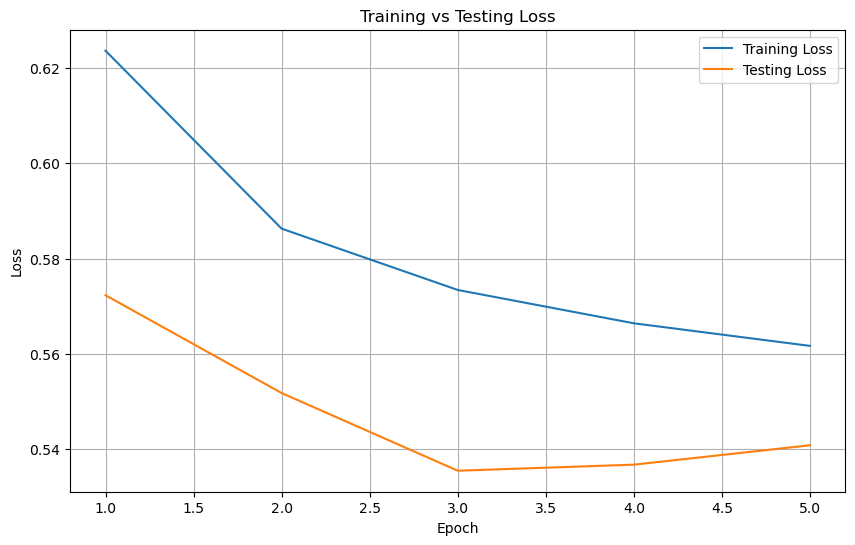

Loss plot saved to output/EEG_CNN-loss_plot.png
Final Training Loss: 0.5617, Final Testing Loss: 0.5409


In [13]:
import os
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from tqdm import tqdm

# Initialize Model, Loss, Optimizer
model = EEG_CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping and Scheduler
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Logging Setup
num_epochs = 5
train_losses = []
test_losses = []
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"

with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

# Training Loop
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    # Logging
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")

    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    # Early Stopping Check
    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save Model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Stats
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


In [14]:
results = evaluate_model(model, test_loader, device)

📊 Evaluation Metrics:
MAE  : 0.5640
MSE  : 0.5409
RMSE : 0.7354
R²   : 0.4592
MAPE : 330.32%


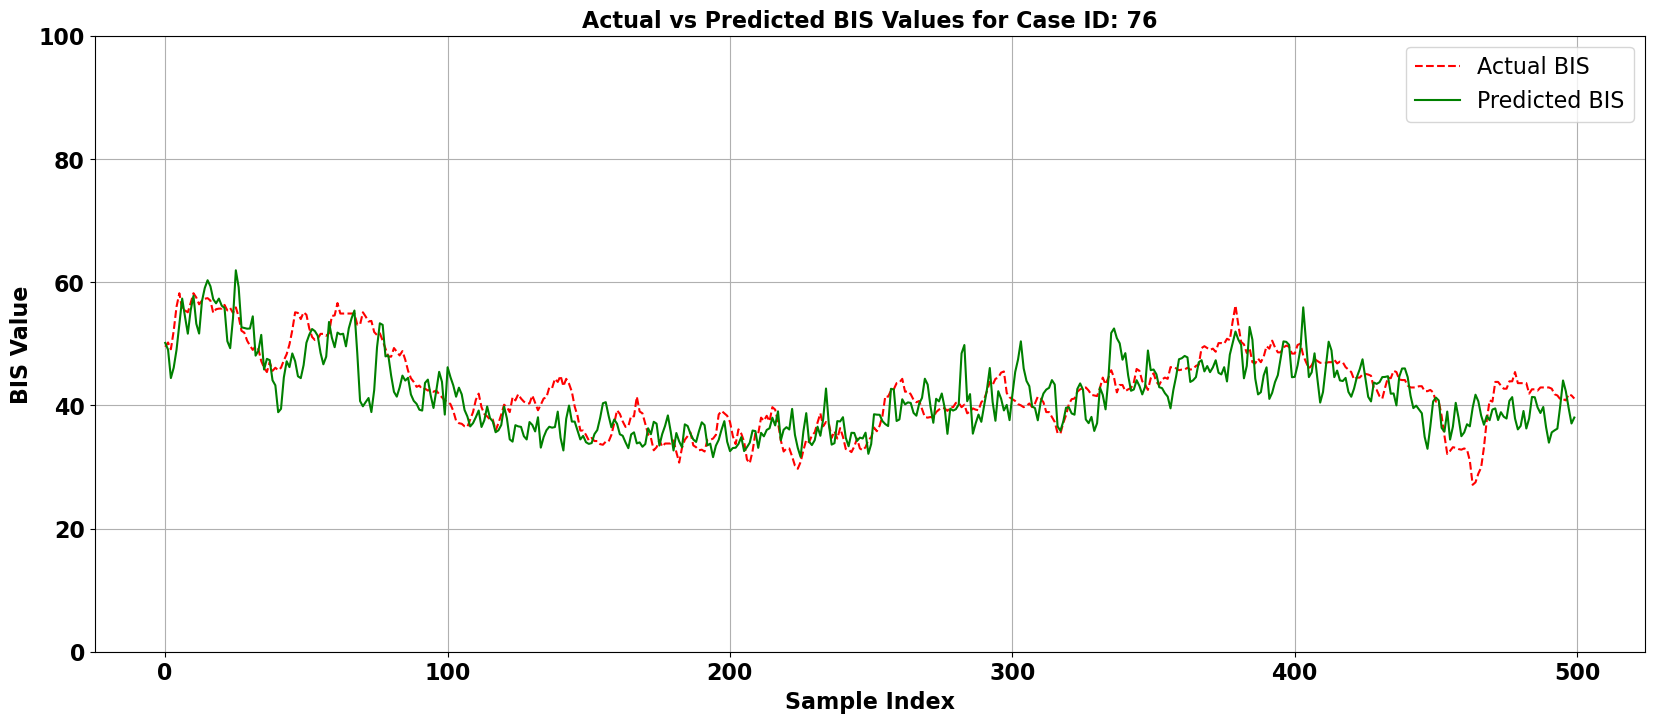

Plot saved to output/EEG_CNN-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [15]:
act_vs_pred(10, model)

### Grad-CAM for Conv1D Models (e.g., EEG_CNN, CNN_LSTM, TCN)

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAM1D:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        input_tensor = input_tensor.to(device)
        input_tensor.requires_grad = True

        output = self.model(input_tensor)
        output.backward(torch.ones_like(output))

        weights = torch.mean(self.gradients, dim=2, keepdim=True)  # (B, C, 1)
        cam = torch.sum(weights * self.activations, dim=1)         # (B, L)
        cam = F.relu(cam)

        # Normalize
        cam -= cam.min(dim=1, keepdim=True)[0]
        cam /= cam.max(dim=1, keepdim=True)[0] + 1e-6

        return cam.cpu().numpy()  # shape: (B, L)


In [17]:
def visualize_gradcam_1d(model, x_tensor, y_true, target_layer, title="Grad-CAM"):
    gradcam = GradCAM1D(model, target_layer)

    # 💡 Fix input shape: (B, C, L)
    if x_tensor.ndim == 1:  # (512,)
        x_tensor = x_tensor.unsqueeze(0).unsqueeze(0)
    elif x_tensor.ndim == 2:  # (1, 512)
        x_tensor = x_tensor.unsqueeze(1)
    elif x_tensor.ndim == 3 and x_tensor.shape[1] != 1:
        x_tensor = x_tensor.permute(0, 2, 1)  # (B, 1, L)

    cam = gradcam.generate(x_tensor)[0]
    signal = x_tensor.squeeze().cpu().numpy()

    # 📈 Plot
    plt.figure(figsize=(15, 5))
    plt.plot(signal, label="EEG Signal", alpha=0.7)
    plt.plot(cam, label="Grad-CAM", color="red", linewidth=2)
    plt.title(f"{title} | True BIS: {y_true:.2f}", fontsize=14)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Amplitude / Importance", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


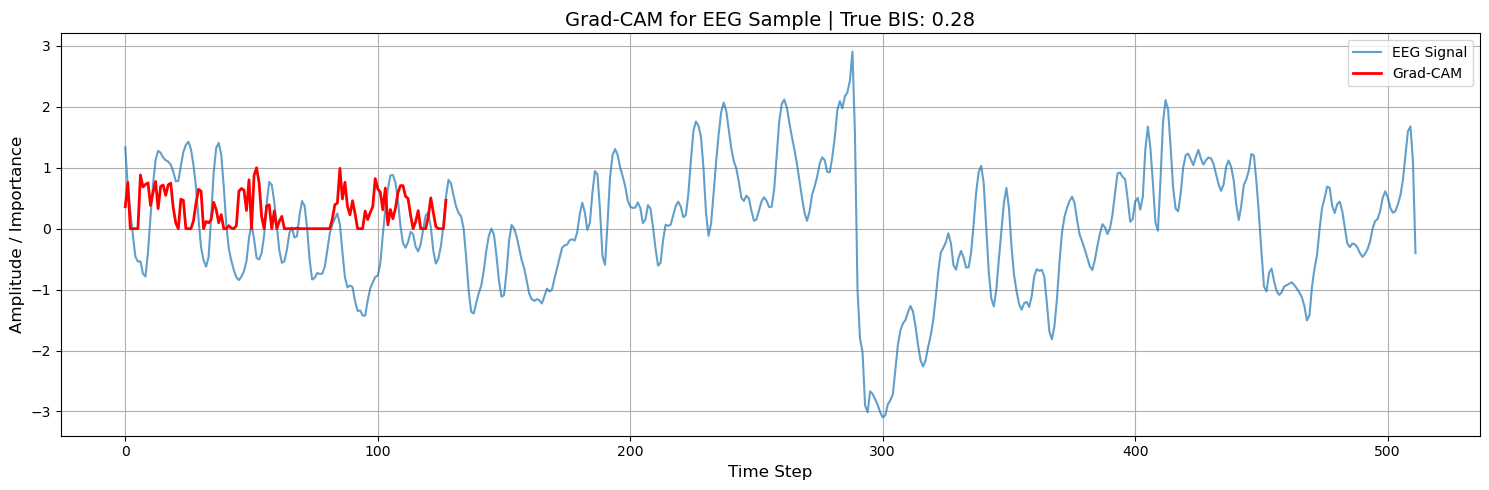

In [18]:
# Pick a test sample
sample_index = 20
x_sample = x_test_tensor[sample_index]  # shape: (512,)
y_sample = y_test_tensor[sample_index].item()

# Choose the last Conv1d layer from your model
target_layer = model.cnn[-3]  # For EEG_CNN, CNN_LSTM, etc.

# Generate Grad-CAM
visualize_gradcam_1d(model, x_sample, y_sample, target_layer, title="Grad-CAM for EEG Sample")


### LIME

In [19]:
import lime
import lime.lime_tabular
import numpy as np
import torch

# 1. Prepare data
X_np = x_test_tensor.squeeze(1).cpu().numpy()  # shape: (N, 512), squeeze channel if needed

# 2. Define predict function for LIME
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # ✅ Ensure model is on correct device

def predict_fn(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32).unsqueeze(1).to(device)  # shape: (batch, 1, 512)
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy()
    return output

# 3. Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_np,
    mode="regression",
    feature_names=[f"EEG_{i}" for i in range(X_np.shape[1])],
    verbose=True,
    random_state=42
)

# 4. Choose a test sample to explain
i = 5
explanation = explainer.explain_instance(
    data_row=X_np[i],
    predict_fn=predict_fn,
    num_features=20
)

# 5. Visualize explanation
explanation.show_in_notebook(show_table=True)



Intercept 1.2168581567227164
Prediction_local [1.03395777]
Right: 0.19968082


### Integrated Gradients

c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


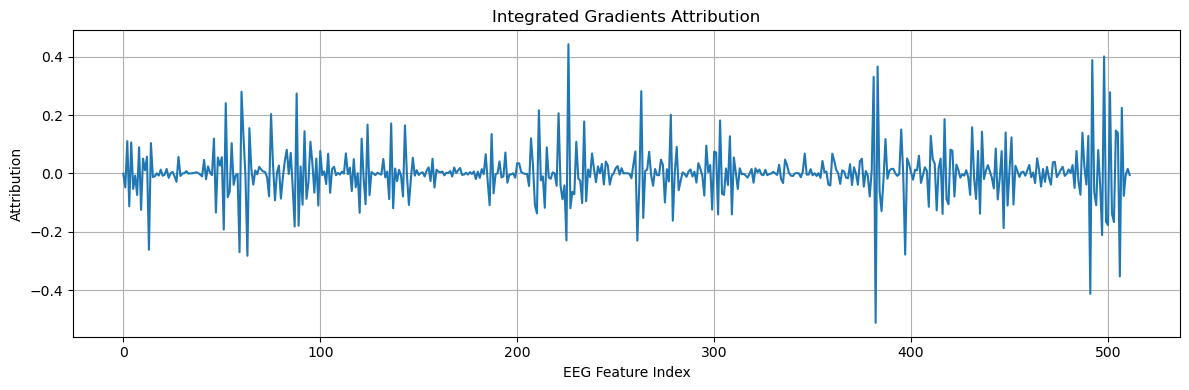

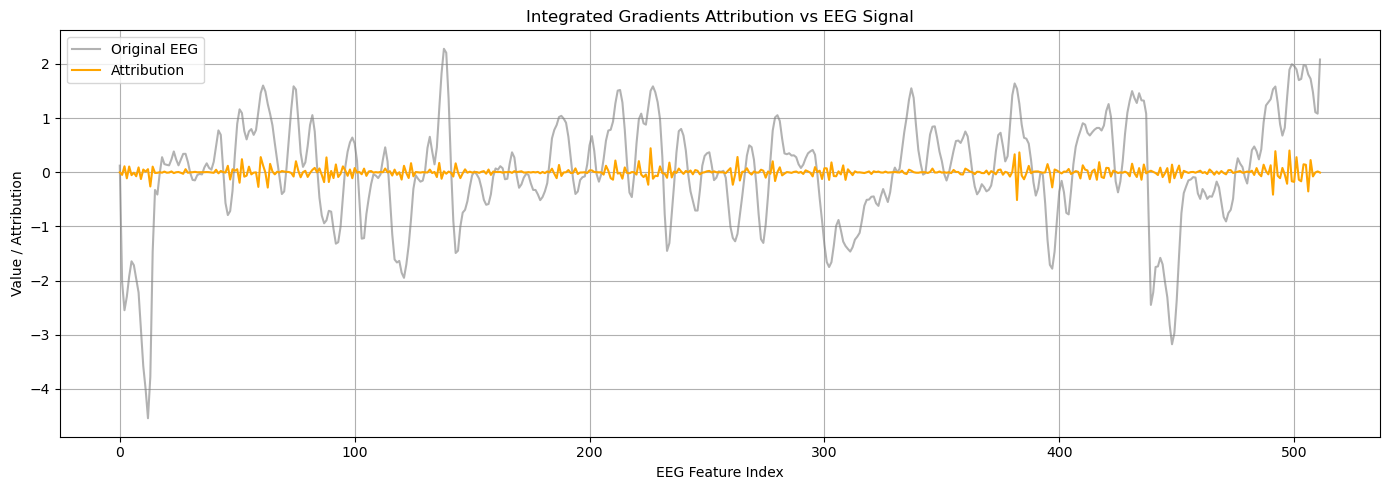

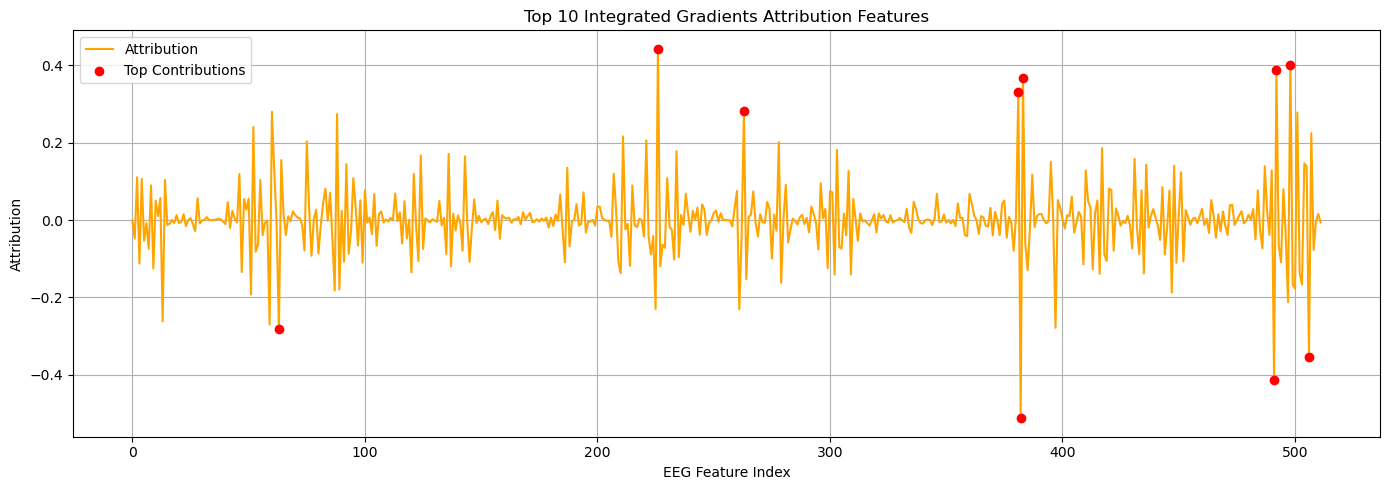

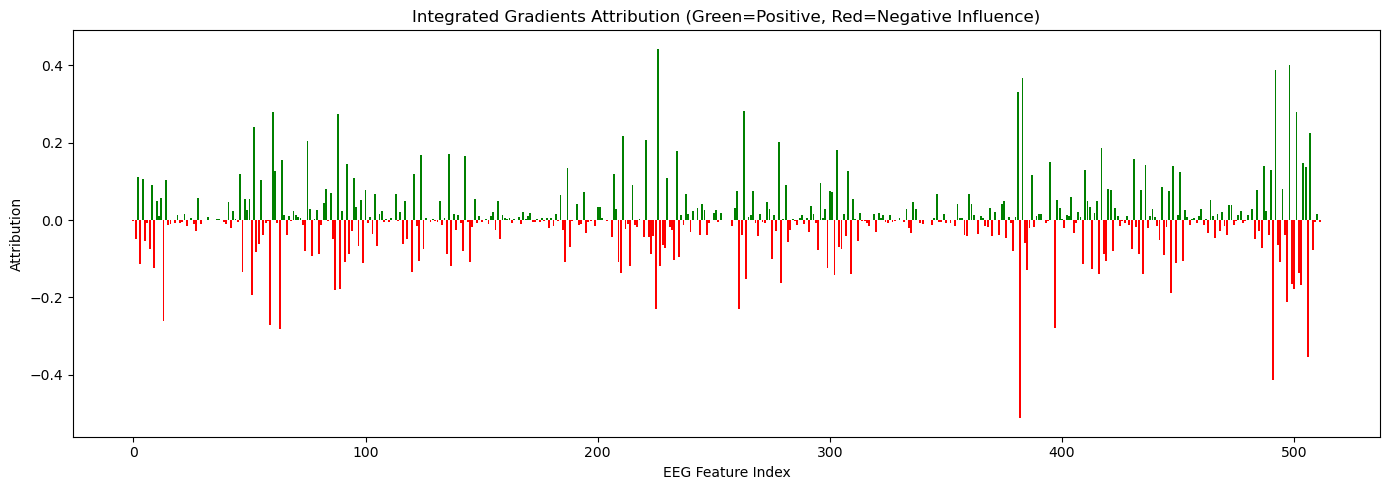

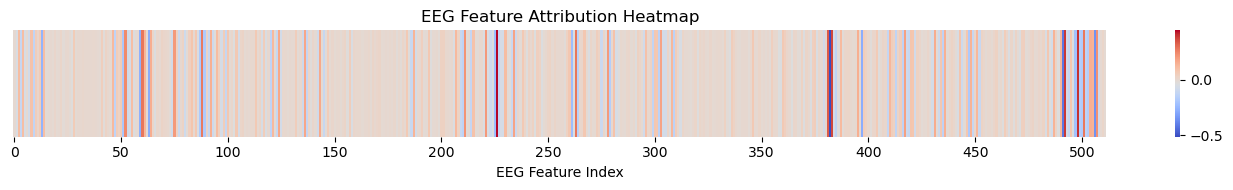

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import seaborn as sns

# 1. Wrap model to fix output shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)  # From [] → [1, 1]
        elif output.ndim == 1:
            output = output.unsqueeze(1)  # From [B] → [B, 1]
        return output

wrapped_model = CaptumWrapper(model).to(device)

# 2. Pick a sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(1)         # Shape: (1, 1, 512)

# 3. Baseline (zero input)
baseline = torch.zeros_like(X_explain).to(device)

# 4. Initialize Integrated Gradients
ig = IntegratedGradients(wrapped_model)

# 5. Get attributions
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Plot results
attr_np = attributions.squeeze().detach().cpu().numpy()  # Shape: (512,)
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()



# Make sure `attr_np` and `X_explain` are already defined
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

# ─────────────────────────────────────────────
# PLOT 1: Attribution vs. EEG Signal
plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.title("Integrated Gradients Attribution vs EEG Signal")
plt.xlabel("EEG Feature Index")
plt.ylabel("Value / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 2: Top-N Feature Contributions
plt.figure(figsize=(14, 5))
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Contributions", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Attribution Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 3: Bar Chart (Color: Direction of Influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("Integrated Gradients Attribution (Green=Positive, Red=Negative Influence)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 4: Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## LSTM

In [21]:
import torch
import torch.nn as nn

class EEG_LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.3):
        super(EEG_LSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False  # You can change to True if desired
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (batch_size, seq_len, 1)

        out, _ = self.lstm(x)  # Output shape: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]    # Take the last output (many-to-one)
        out = self.fc(out)     # Final regression output
        return out.squeeze()


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
 20%|██        | 1/5 [01:45<07:02, 105.67s/it]

Epoch 1/5, Training Loss: 0.9019, Testing Loss: 0.7439, LR: 0.000100


 40%|████      | 2/5 [03:31<05:17, 105.69s/it]

Epoch 2/5, Training Loss: 0.7599, Testing Loss: 0.7005, LR: 0.000100


 60%|██████    | 3/5 [05:10<03:25, 102.85s/it]

Epoch 3/5, Training Loss: 0.7147, Testing Loss: 0.6473, LR: 0.000100


 80%|████████  | 4/5 [06:56<01:44, 104.01s/it]

Epoch 4/5, Training Loss: 0.6909, Testing Loss: 0.6693, LR: 0.000100


100%|██████████| 5/5 [08:40<00:00, 104.14s/it]

Epoch 5/5, Training Loss: 0.6849, Testing Loss: 0.6559, LR: 0.000100
Model saved to output/EEG_LSTM-model.pth


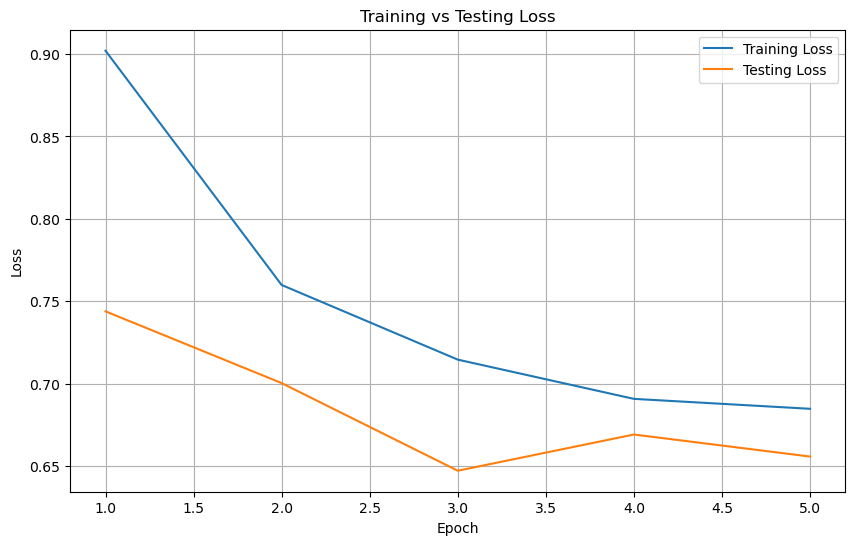

Loss plot saved to output/EEG_LSTM-loss_plot.png
Final Training Loss: 0.6849, Final Testing Loss: 0.6559


In [22]:
# Initialize Model
model = EEG_LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping and Scheduler
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Logging
num_epochs = 5
train_losses = []
test_losses = []

os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"
with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

# Training Loop
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        # LSTM expects (batch, seq_len, input_dim)
        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(-1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(-1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")

    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save Model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Stats
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


📊 Evaluation Metrics:
MAE  : 0.6257
MSE  : 0.6559
RMSE : 0.8099
R²   : 0.3442
MAPE : 394.56%


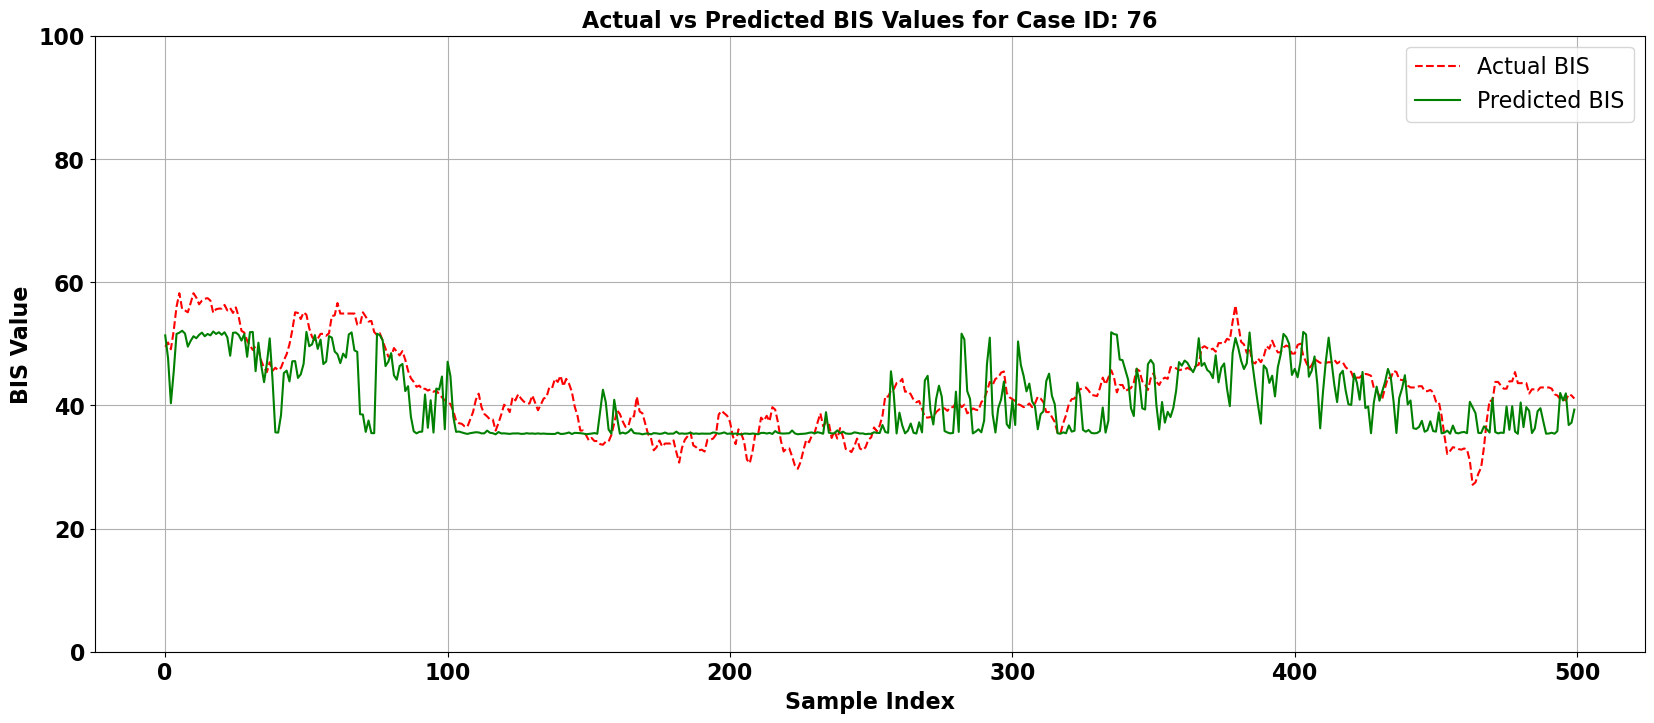

Plot saved to output/EEG_LSTM-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [23]:
results = evaluate_model(model, test_loader, device)
act_vs_pred(10, model)

### LIME

Intercept 1.2596417611070327
Prediction_local [1.14065935]
Right: -0.6433338


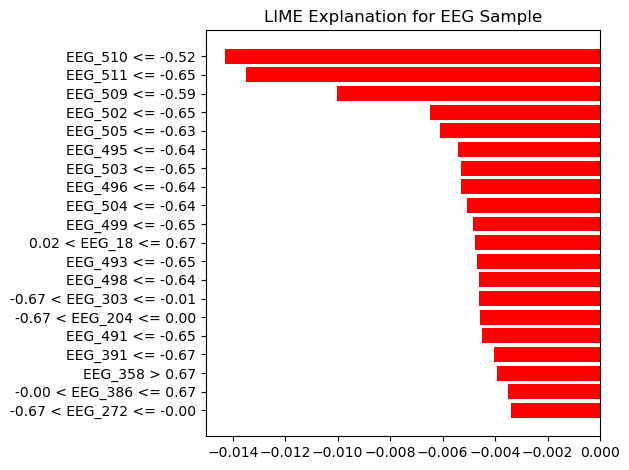

In [24]:
# Remove all forward/backward hooks to clean up LSTM state
def remove_all_hooks(model):
    for module in model.modules():
        if hasattr(module, "_forward_hooks"):
            module._forward_hooks.clear()
        if hasattr(module, "_backward_hooks"):
            module._backward_hooks.clear()
        if hasattr(module, "_forward_pre_hooks"):
            module._forward_pre_hooks.clear()
        if hasattr(module, "_backward_pre_hooks"):
            module._backward_pre_hooks.clear()

remove_all_hooks(model)


import torch
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# 🧹 Clean lingering hooks from LSTM if any
remove_all_hooks(model)

# ✅ Prepare input
X_np = x_test_tensor.cpu().numpy()  # (N, 512) or (N, 1, 512)
if X_np.ndim == 3:
    X_np = X_np.squeeze(1)  # Now (N, 512)

# ✅ LIME prediction function
def predict_fn(input_numpy):
    input_tensor = torch.tensor(input_numpy, dtype=torch.float32).unsqueeze(-1).to(device)  # (B, 512, 1)
    with torch.no_grad():
        output = model(input_tensor).cpu().numpy()
    return output

# ✅ Init explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_np,
    mode="regression",
    feature_names=[f"EEG_{i}" for i in range(X_np.shape[1])],
    verbose=True,
    random_state=42
)

# ✅ Explain sample
i = 5
explanation = explainer.explain_instance(
    data_row=X_np[i],
    predict_fn=predict_fn,
    num_features=20
)

# ✅ Show explanation
explanation.show_in_notebook(show_table=True)

# Optional: Plot
fig = explanation.as_pyplot_figure(label=0)
plt.title("LIME Explanation for EEG Sample")
plt.tight_layout()
plt.show()



### Integrated Gradients

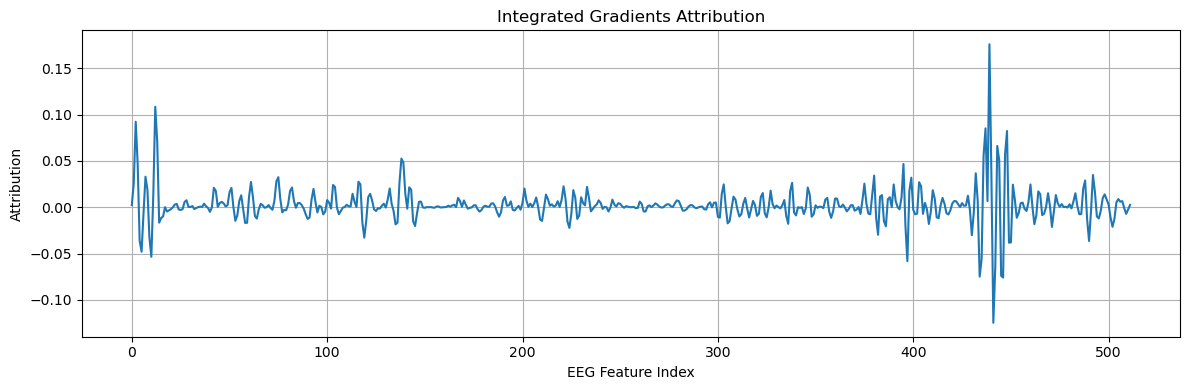

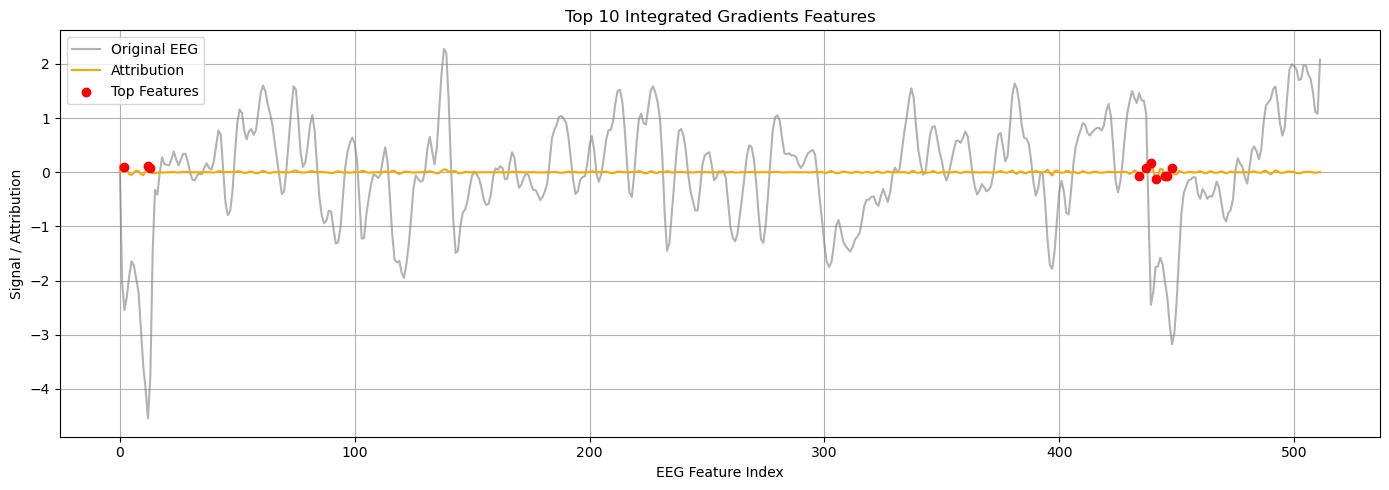

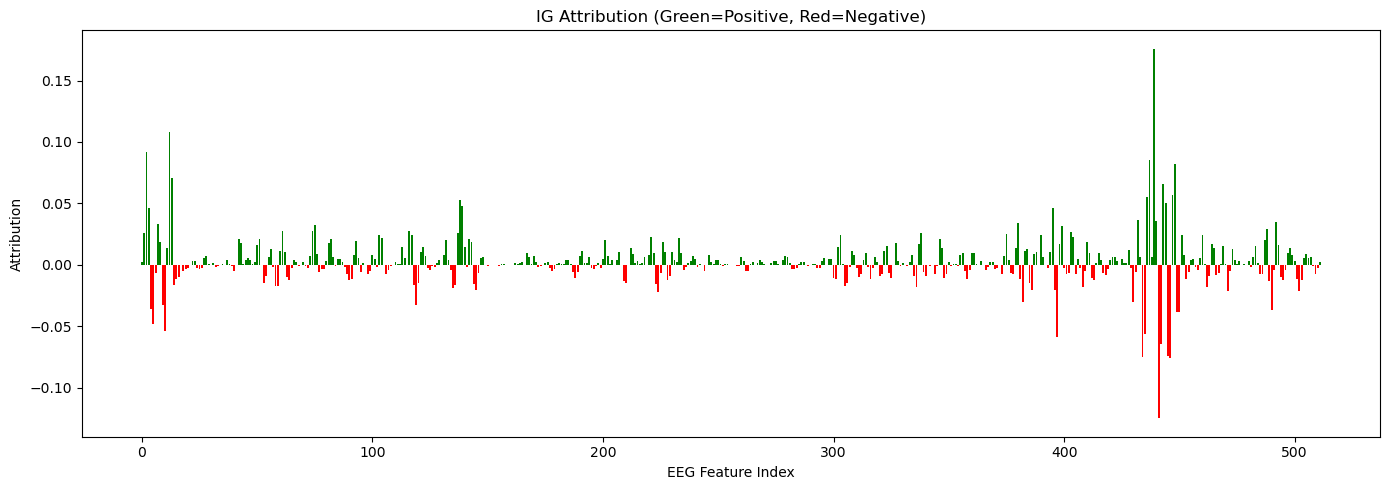

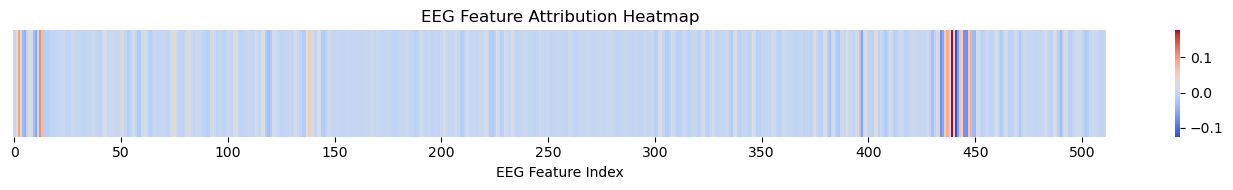

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)
        elif output.ndim == 1:
            output = output.unsqueeze(1)
        return output

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # ✅ Required for cuDNN backward in LSTM

# 3. Pick a test sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(-1)        # (1, 512, 1)

# 4. Baseline for Integrated Gradients
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Signal / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot (Positive/Negative influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("IG Attribution (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## AttentionLSTM

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.3):
        super(AttentionLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )

        # Attention layer: maps LSTM hidden state to scalar attention score
        self.attn = nn.Linear(hidden_dim, 1)

        # Fully connected output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (batch, seq_len, 1)

        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        attn_weights = F.softmax(self.attn(lstm_out), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)   # (batch, hidden_dim)
        output = self.fc(context)                              # (batch, 1)
        return output.squeeze()


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:56<07:44, 116.14s/it]

Epoch 1/5, Training Loss: 0.8138, Testing Loss: 0.6534, LR: 0.000100


 40%|████      | 2/5 [03:50<05:45, 115.26s/it]

Epoch 2/5, Training Loss: 0.6797, Testing Loss: 0.5979, LR: 0.000100


 60%|██████    | 3/5 [05:41<03:46, 113.33s/it]

Epoch 3/5, Training Loss: 0.6499, Testing Loss: 0.5846, LR: 0.000100


 80%|████████  | 4/5 [07:30<01:51, 111.69s/it]

Epoch 4/5, Training Loss: 0.6248, Testing Loss: 0.6091, LR: 0.000100


100%|██████████| 5/5 [09:23<00:00, 112.60s/it]

Epoch 5/5, Training Loss: 0.6009, Testing Loss: 0.5983, LR: 0.000100
Model saved to output/AttentionLSTM-model.pth


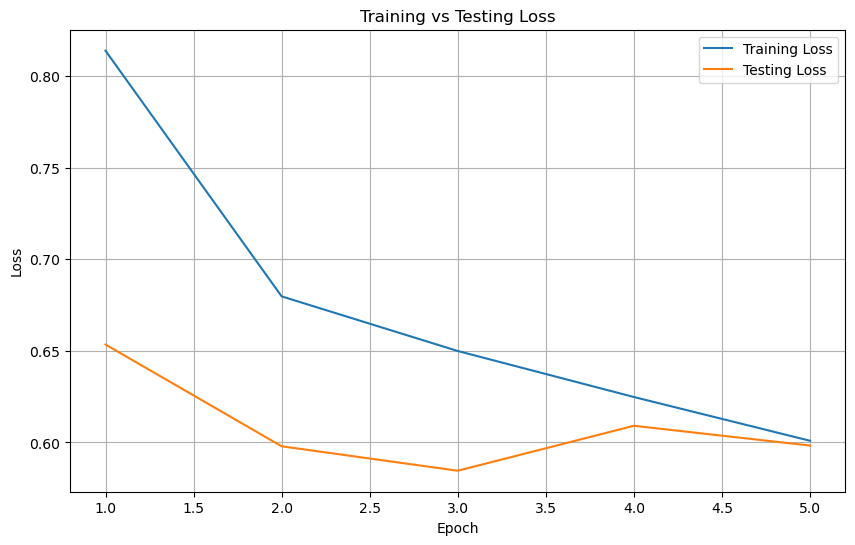

Loss plot saved to output/AttentionLSTM-loss_plot.png
Final Training Loss: 0.6009, Final Testing Loss: 0.5983


In [27]:
# Initialize Model, Loss, Optimizer
model = AttentionLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early Stopping and LR Scheduler
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Training Setup
num_epochs = 5
train_losses = []
test_losses = []

os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"
with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

# Training Loop
from tqdm import tqdm
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(-1)  # (batch, 256, 1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(-1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")

    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save Model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Results
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


📊 Evaluation Metrics:
MAE  : 0.6046
MSE  : 0.5983
RMSE : 0.7735
R²   : 0.4017
MAPE : 302.75%


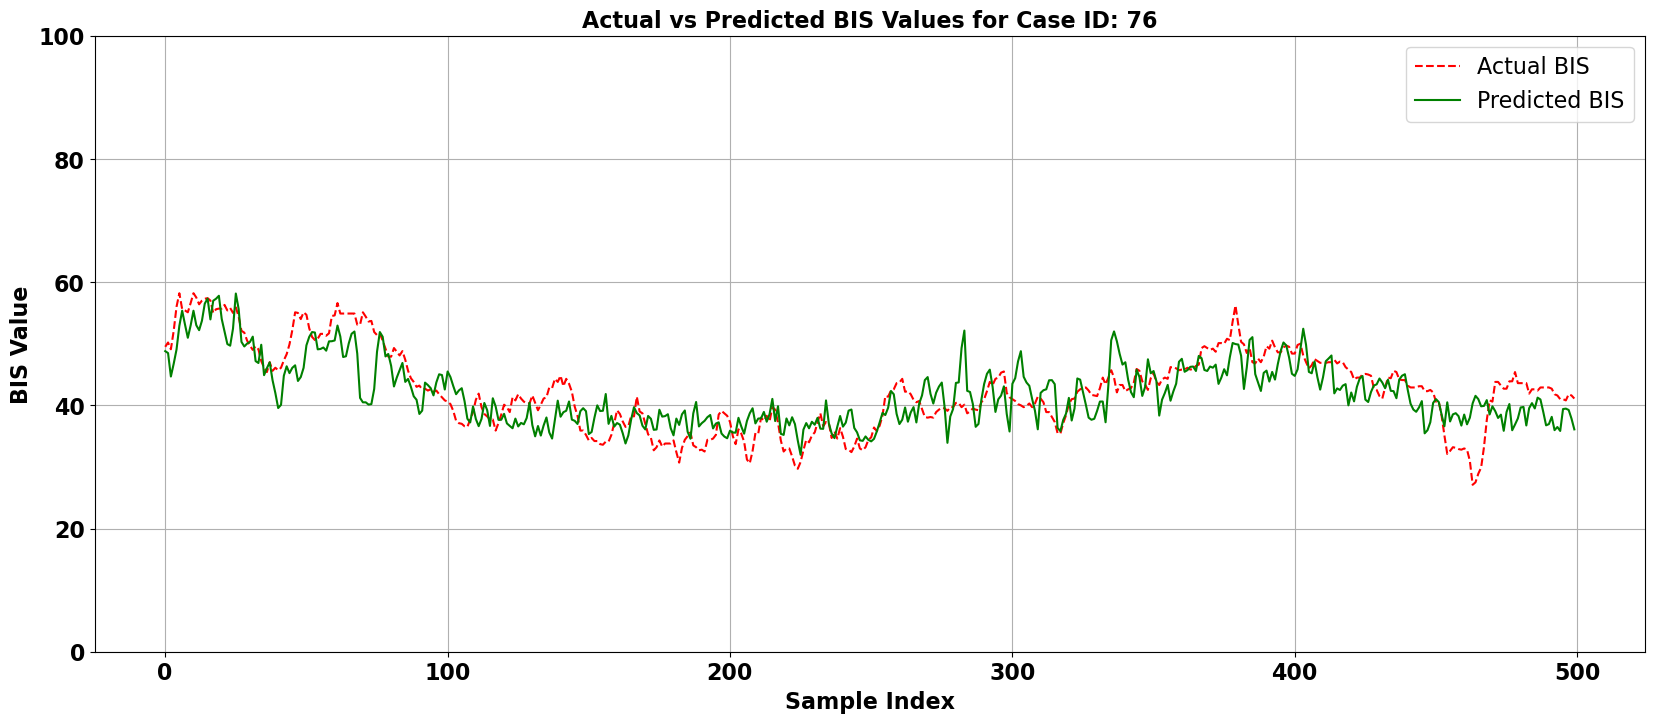

Plot saved to output/AttentionLSTM-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [28]:
results = evaluate_model(model, test_loader, device)
act_vs_pred(10, model)

### Integrated Gradients

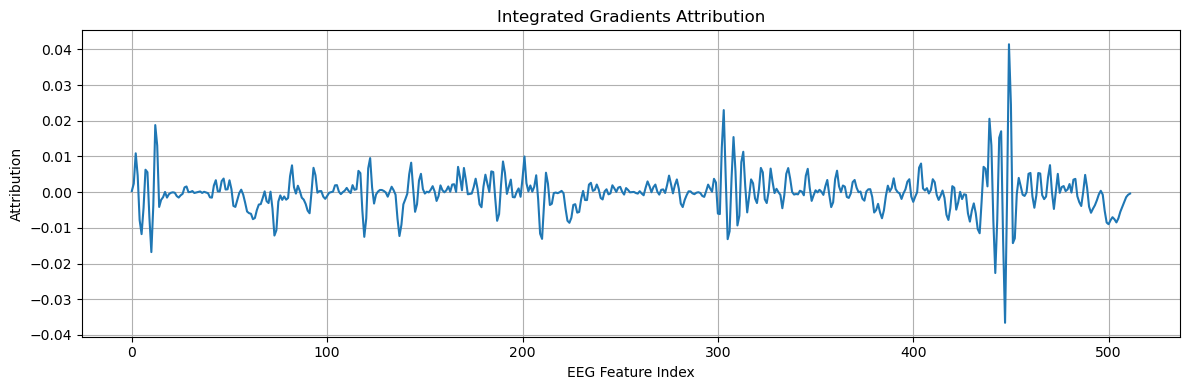

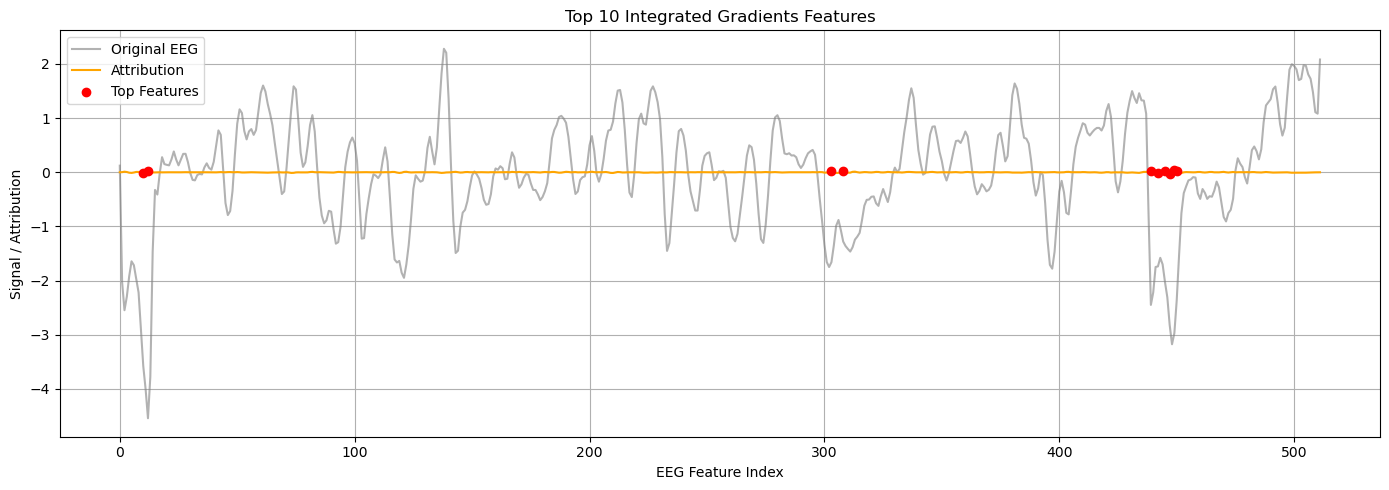

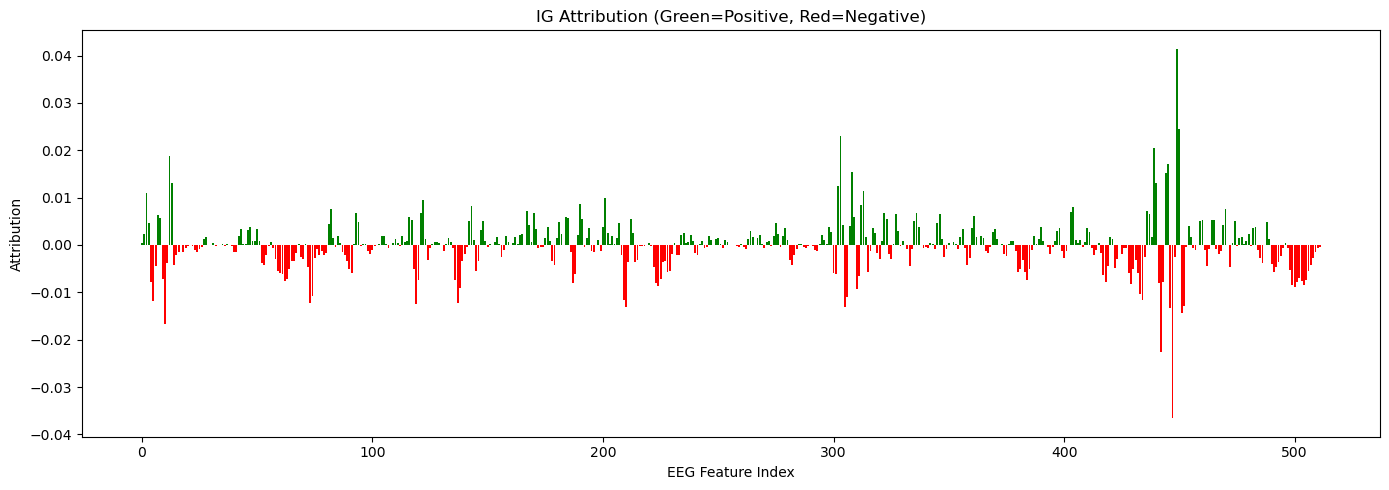

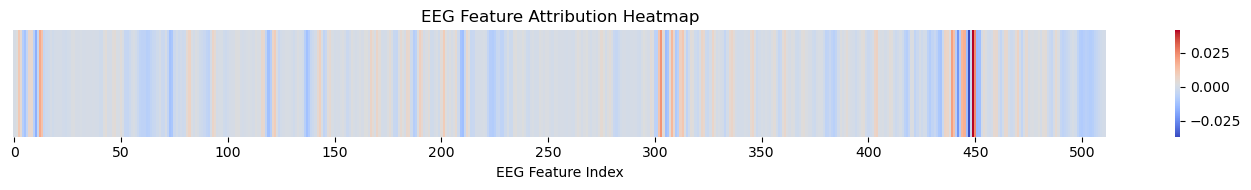

In [29]:
### Integrated Gradients
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)
        elif output.ndim == 1:
            output = output.unsqueeze(1)
        return output

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # ✅ Required for cuDNN backward in LSTM

# 3. Pick a test sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(-1)        # (1, 512, 1)

# 4. Baseline for Integrated Gradients
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Signal / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot (Positive/Negative influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("IG Attribution (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## CNN-LSTM

In [30]:
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_length=256, cnn_out_channels=32, lstm_hidden_dim=64, lstm_layers=2, dropout=0.3):
        super(CNN_LSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 256 → 128

            nn.Conv1d(16, cnn_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)   # 128 → 64
        )

        # After 2 MaxPool1d layers
        self.seq_len_after_cnn = input_length // 4

        self.lstm = nn.LSTM(
            input_size=cnn_out_channels,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Input shape: (batch, 256) → (batch, 1, 256)
        if x.ndim == 2:
            x = x.unsqueeze(1)
        elif x.ndim == 3 and x.shape[1] != 1:
            x = x.permute(0, 2, 1)

        x = self.cnn(x)                 # → (batch, channels, seq_len)
        x = x.permute(0, 2, 1)         # → (batch, seq_len, channels)
        x, _ = self.lstm(x)            # → (batch, seq_len, hidden_dim)
        x = x[:, -1, :]                # Take last time step
        out = self.fc(x)               # → (batch, 1)
        return out.squeeze()


 20%|██        | 1/5 [01:55<07:43, 115.99s/it]

Epoch 1/5, Training Loss: 0.6657, Testing Loss: 0.6084, LR: 0.000100


 40%|████      | 2/5 [03:49<05:43, 114.55s/it]

Epoch 2/5, Training Loss: 0.6083, Testing Loss: 0.5590, LR: 0.000100


 60%|██████    | 3/5 [05:00<03:09, 94.77s/it] 

Epoch 3/5, Training Loss: 0.5835, Testing Loss: 0.5539, LR: 0.000100


 80%|████████  | 4/5 [06:11<01:25, 85.19s/it]

Epoch 4/5, Training Loss: 0.5649, Testing Loss: 0.5421, LR: 0.000100


100%|██████████| 5/5 [07:21<00:00, 88.21s/it]

Epoch 5/5, Training Loss: 0.5511, Testing Loss: 0.5175, LR: 0.000100
Model saved to output/CNN_LSTM-model.pth


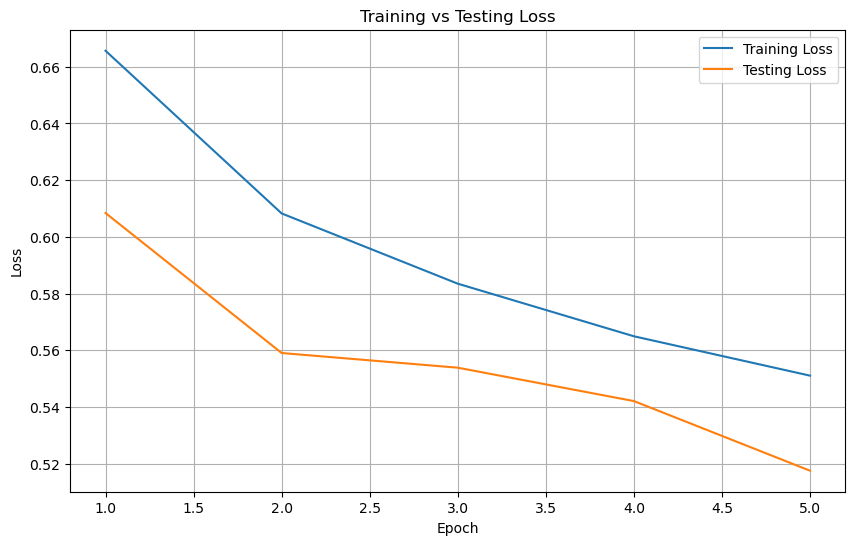

Loss plot saved to output/CNN_LSTM-loss_plot.png
Final Training Loss: 0.5511, Final Testing Loss: 0.5175


In [31]:
model = CNN_LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early stopping + scheduler
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# Logging setup
num_epochs = 5
train_losses = []
test_losses = []

import os
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"
with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

from tqdm import tqdm
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        # Shape handling
        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(1)
        elif batch_x.ndim == 3 and batch_x.shape[1] != 1:
            batch_x = batch_x.permute(0, 2, 1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(1)
            elif batch_x.ndim == 3 and batch_x.shape[1] != 1:
                batch_x = batch_x.permute(0, 2, 1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    # Log and print
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save Model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Summary
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


📊 Evaluation Metrics:
MAE  : 0.5451
MSE  : 0.5175
RMSE : 0.7194
R²   : 0.4825
MAPE : 304.66%


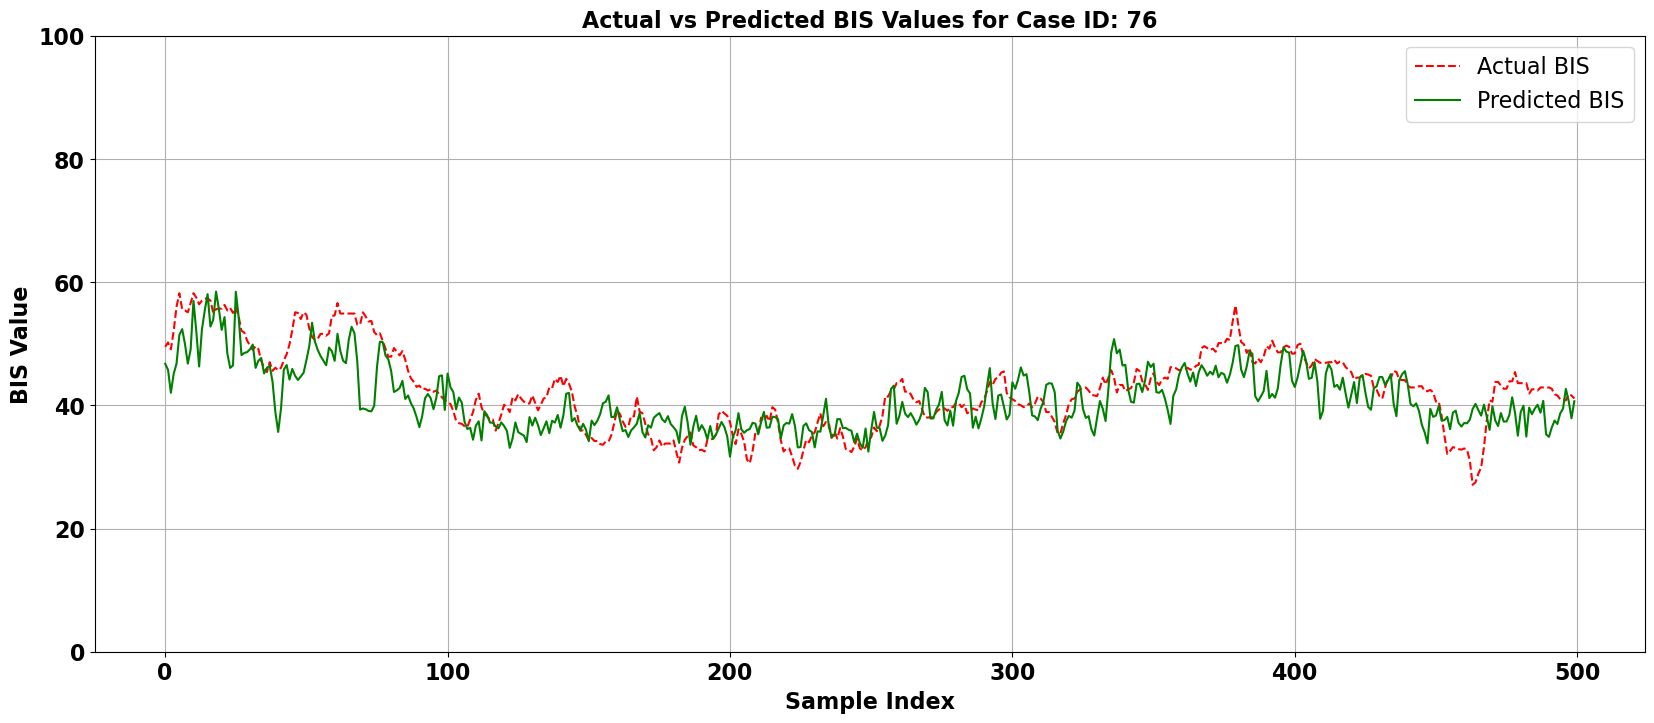

Plot saved to output/CNN_LSTM-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [32]:
results = evaluate_model(model, test_loader, device)
act_vs_pred(10, model)

### Integrated Gradients

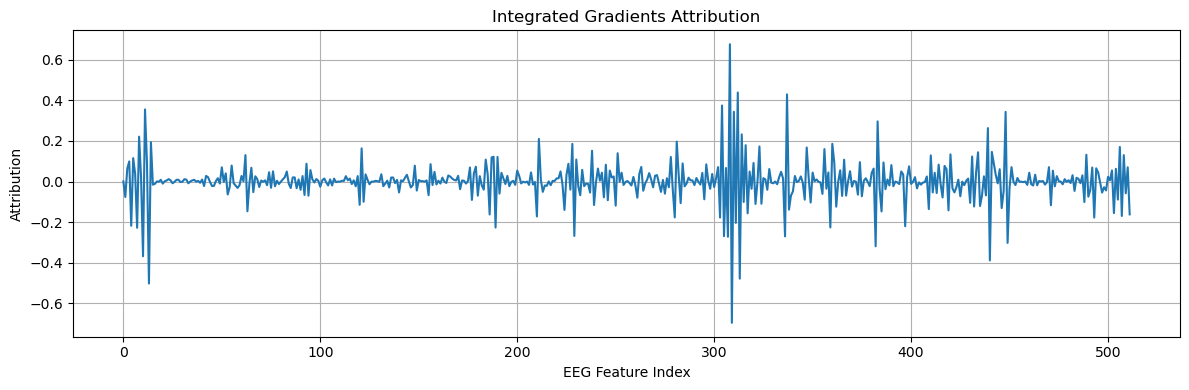

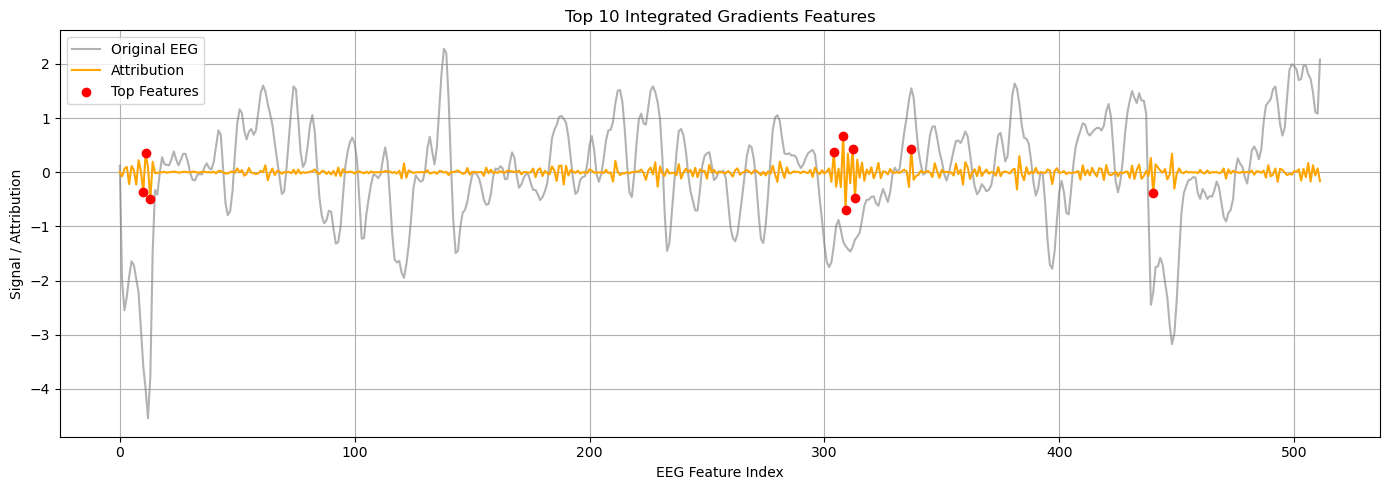

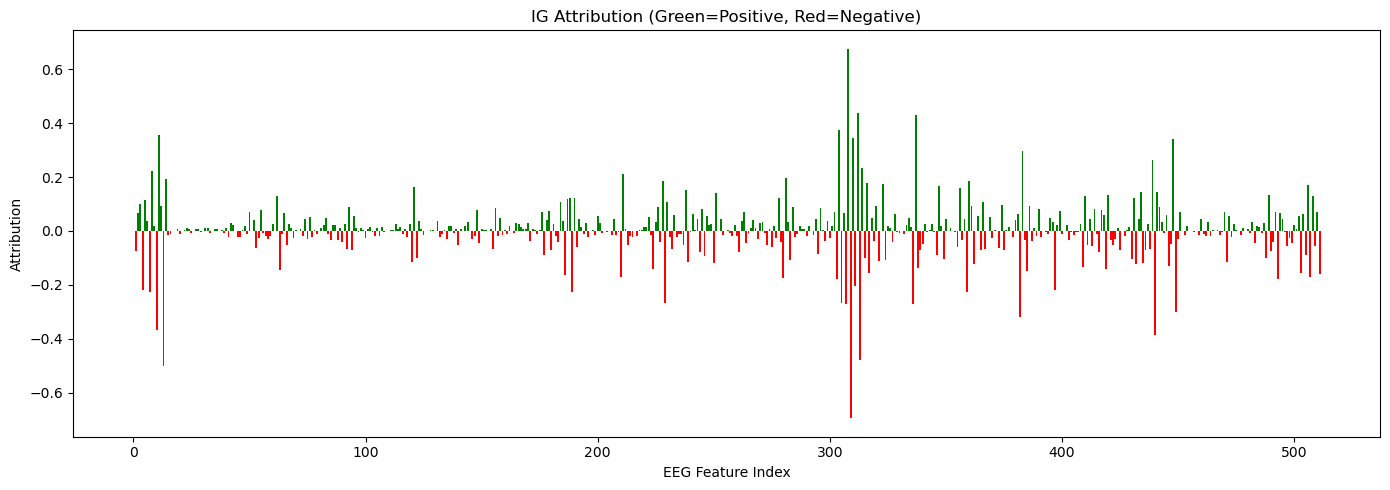

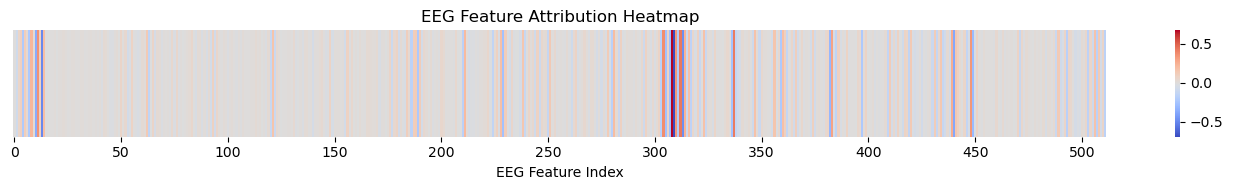

In [33]:
### Integrated Gradients
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)
        elif output.ndim == 1:
            output = output.unsqueeze(1)
        return output

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # ✅ Required for cuDNN backward in LSTM

# 3. Pick a test sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(-1)        # (1, 512, 1)

# 4. Baseline for Integrated Gradients
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Signal / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot (Positive/Negative influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("IG Attribution (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## CNN + BiLSTM + Attention

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_length=256, cnn_out_channels=32, lstm_hidden_dim=64, lstm_layers=2, dropout=0.3):
        super(CNN_BiLSTM_Attention, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, cnn_out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_out_channels),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.seq_len_after_cnn = input_length // 4  # 256 → 64
        self.cnn_out = cnn_out_channels

        self.lstm = nn.LSTM(
            input_size=cnn_out_channels,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,  # BiLSTM
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        # Attention Layer
        self.attn = nn.Linear(lstm_hidden_dim * 2, 1)  # Because bidirectional

        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(1)
        elif x.ndim == 3 and x.shape[1] != 1:
            x = x.permute(0, 2, 1)

        x = self.cnn(x)                      # → (batch, channels, seq_len)
        x = x.permute(0, 2, 1)              # → (batch, seq_len, channels)
        lstm_out, _ = self.lstm(x)          # → (batch, seq_len, 2*hidden_dim)
        
        attn_weights = F.softmax(self.attn(lstm_out), dim=1)    # (batch, seq_len, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)     # (batch, 2*hidden_dim)

        out = self.fc(context)              # → (batch, 1)
        return out.squeeze()


 20%|██        | 1/5 [02:14<08:56, 134.06s/it]

Epoch 1/5, Training Loss: 0.6232, Testing Loss: 0.5527, LR: 0.000100


 40%|████      | 2/5 [04:36<06:56, 138.93s/it]

Epoch 2/5, Training Loss: 0.5696, Testing Loss: 0.5334, LR: 0.000100


 60%|██████    | 3/5 [06:21<04:07, 123.63s/it]

Epoch 3/5, Training Loss: 0.5450, Testing Loss: 0.5089, LR: 0.000100


 80%|████████  | 4/5 [08:09<01:57, 117.32s/it]

Epoch 4/5, Training Loss: 0.5231, Testing Loss: 0.5046, LR: 0.000100


100%|██████████| 5/5 [10:32<00:00, 126.42s/it]

Epoch 5/5, Training Loss: 0.5106, Testing Loss: 0.5132, LR: 0.000100
Model saved to output/CNN_BiLSTM_Attention-model.pth


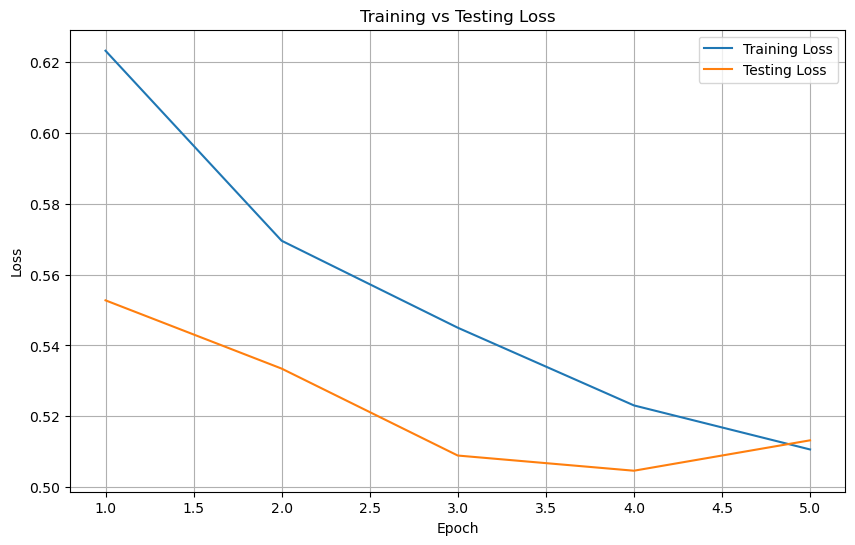

Loss plot saved to output/CNN_BiLSTM_Attention-loss_plot.png
Final Training Loss: 0.5106, Final Testing Loss: 0.5132


In [35]:
model = CNN_BiLSTM_Attention().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Early stopping + scheduler
early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# Logging setup
num_epochs = 5
train_losses = []
test_losses = []

import os
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"
with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

from tqdm import tqdm
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        # Shape handling
        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(1)
        elif batch_x.ndim == 3 and batch_x.shape[1] != 1:
            batch_x = batch_x.permute(0, 2, 1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(1)
            elif batch_x.ndim == 3 and batch_x.shape[1] != 1:
                batch_x = batch_x.permute(0, 2, 1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    # Log and print
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save Model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Summary
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")

📊 Evaluation Metrics:
MAE  : 0.5299
MSE  : 0.5132
RMSE : 0.7164
R²   : 0.4869
MAPE : 345.60%


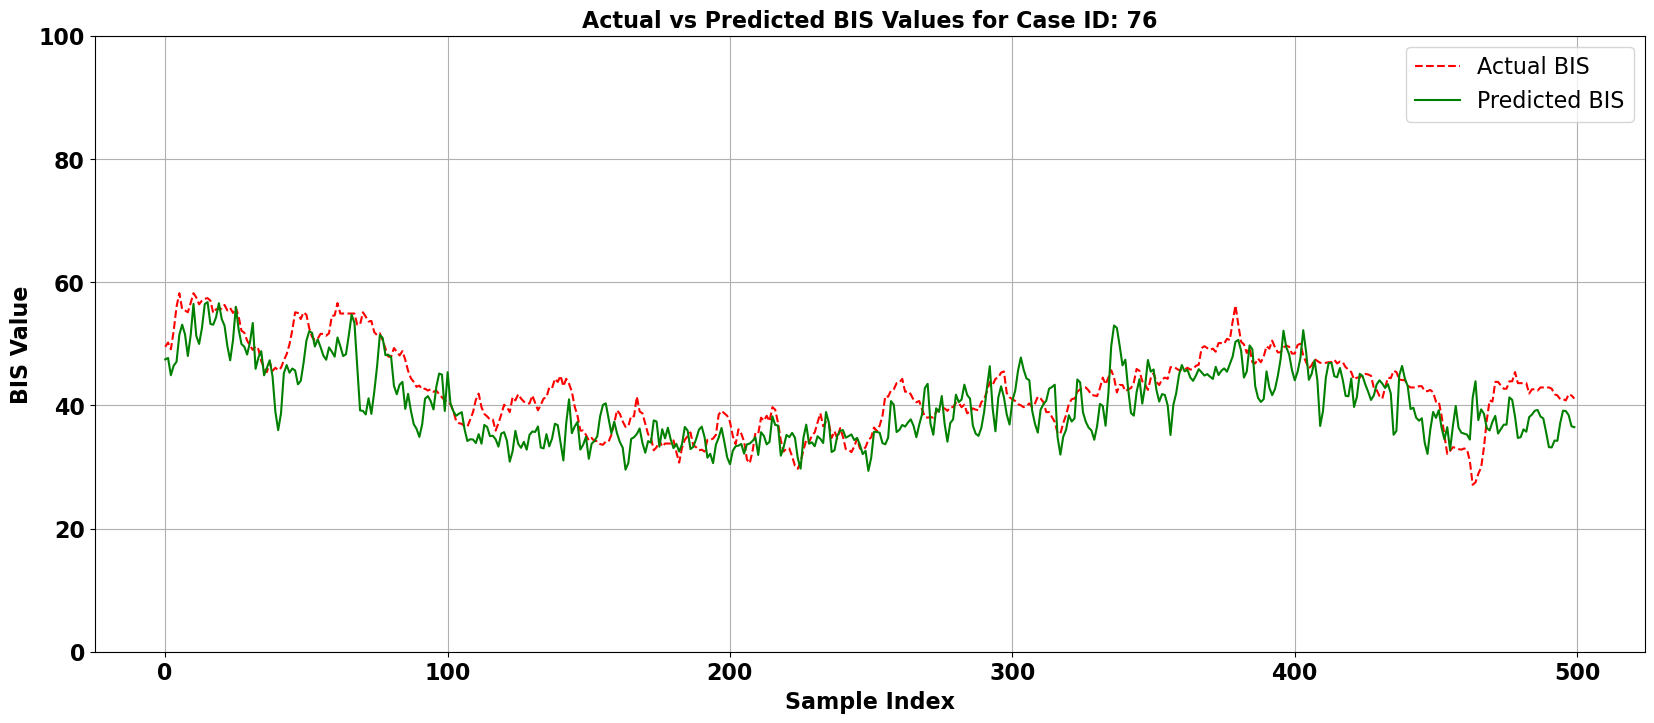

Plot saved to output/CNN_BiLSTM_Attention-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [36]:
results = evaluate_model(model, test_loader, device)
act_vs_pred(10, model)

### Integrated Gradients

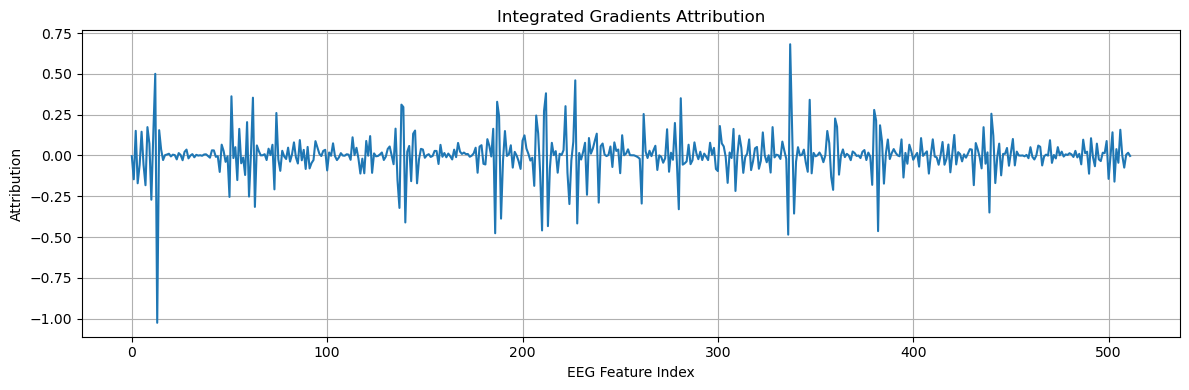

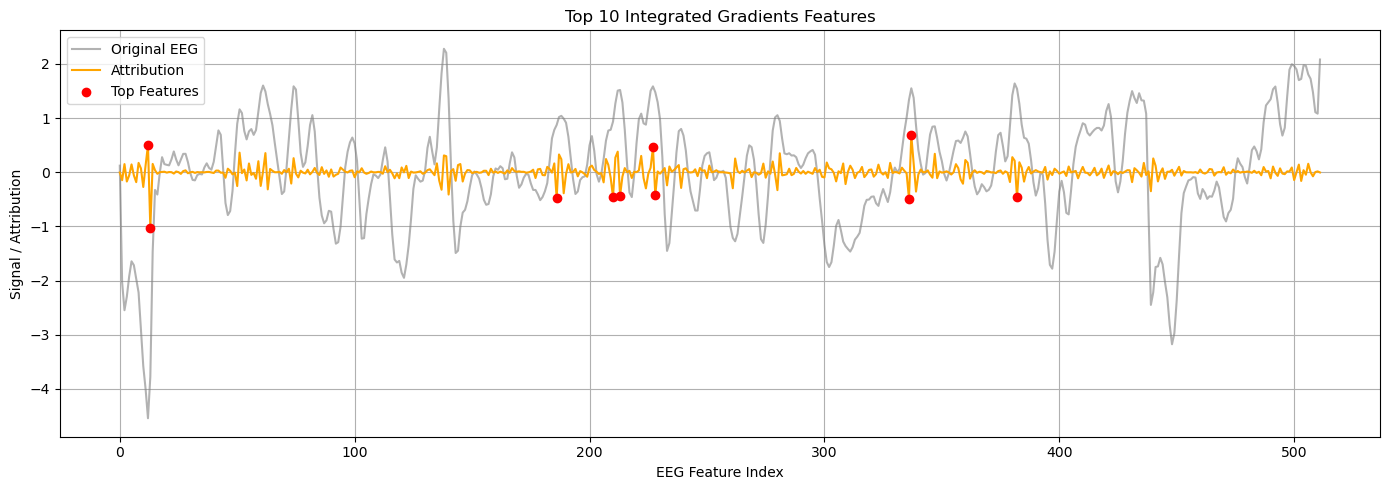

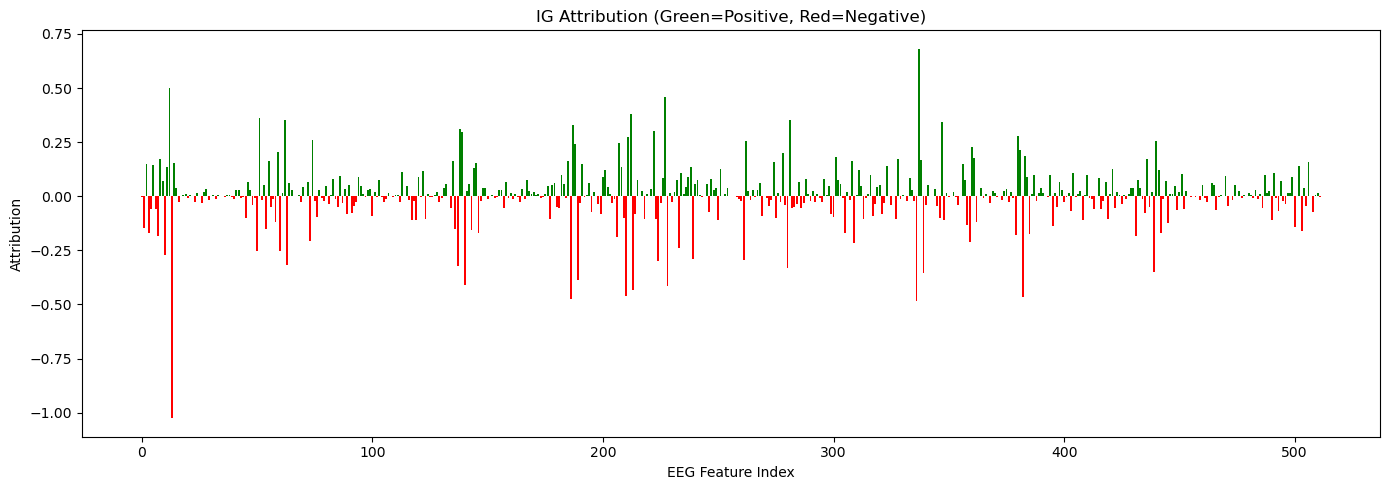

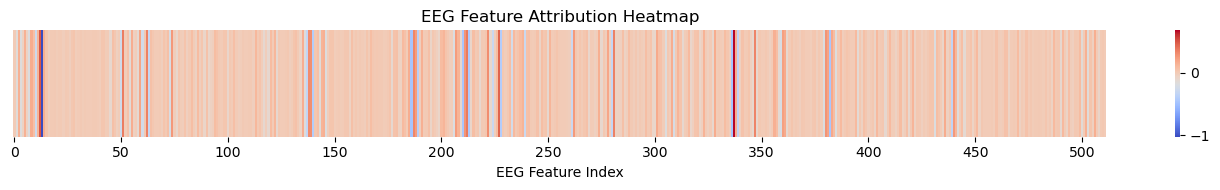

In [37]:
### Integrated Gradients
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)
        elif output.ndim == 1:
            output = output.unsqueeze(1)
        return output

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # ✅ Required for cuDNN backward in LSTM

# 3. Pick a test sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(-1)        # (1, 512, 1)

# 4. Baseline for Integrated Gradients
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Signal / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot (Positive/Negative influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("IG Attribution (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## GRU-Based EEG Regression

In [38]:
import torch
import torch.nn as nn

class EEG_GRU(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.3):
        super(EEG_GRU, self).__init__()

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Input: (batch_size, seq_len) → (batch_size, seq_len, 1)
        if x.ndim == 2:
            x = x.unsqueeze(-1)

        out, _ = self.gru(x)              # → (batch, seq_len, hidden_dim)
        last_out = out[:, -1, :]          # Use last time step
        out = self.fc(last_out)           # → (batch, 1)
        return out.squeeze()


  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:47<07:11, 107.81s/it]

Epoch 1/5, Training Loss: 0.8464, Testing Loss: 0.7129, LR: 0.000100


 40%|████      | 2/5 [03:26<05:07, 102.61s/it]

Epoch 2/5, Training Loss: 0.6741, Testing Loss: 0.6136, LR: 0.000100


 60%|██████    | 3/5 [05:08<03:24, 102.13s/it]

Epoch 3/5, Training Loss: 0.6429, Testing Loss: 0.5722, LR: 0.000100


 80%|████████  | 4/5 [06:52<01:42, 102.94s/it]

Epoch 4/5, Training Loss: 0.6222, Testing Loss: 0.5655, LR: 0.000100


100%|██████████| 5/5 [08:34<00:00, 102.82s/it]

Epoch 5/5, Training Loss: 0.6017, Testing Loss: 0.5681, LR: 0.000100
Model saved to output/EEG_GRU-model.pth


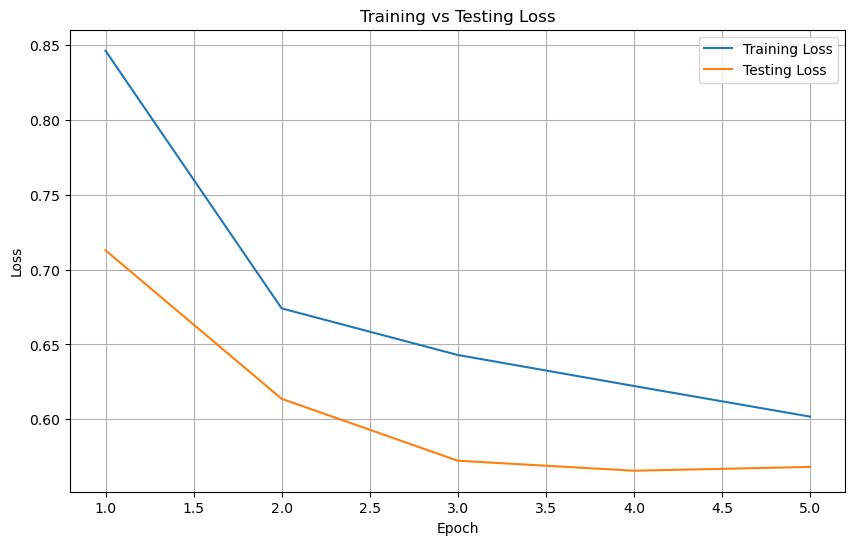

Loss plot saved to output/EEG_GRU-loss_plot.png
Final Training Loss: 0.6017, Final Testing Loss: 0.5681


In [39]:
model = EEG_GRU().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

early_stopping = EarlyStopping(patience=3, min_delta=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

num_epochs = 5
train_losses = []
test_losses = []

import os
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"
with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

from tqdm import tqdm
for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_y = batch_y.squeeze()

        if batch_x.ndim == 2:
            batch_x = batch_x.unsqueeze(-1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Evaluate
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y = batch_y.squeeze()

            if batch_x.ndim == 2:
                batch_x = batch_x.unsqueeze(-1)

            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    scheduler.step(test_losses[-1])

    # Log & print
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    early_stopping(test_losses[-1])
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save model
model_path = f"output/{str(model).split('(')[0]}-model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses)+1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final results
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


📊 Evaluation Metrics:
MAE  : 0.5724
MSE  : 0.5681
RMSE : 0.7537
R²   : 0.4320
MAPE : 342.85%


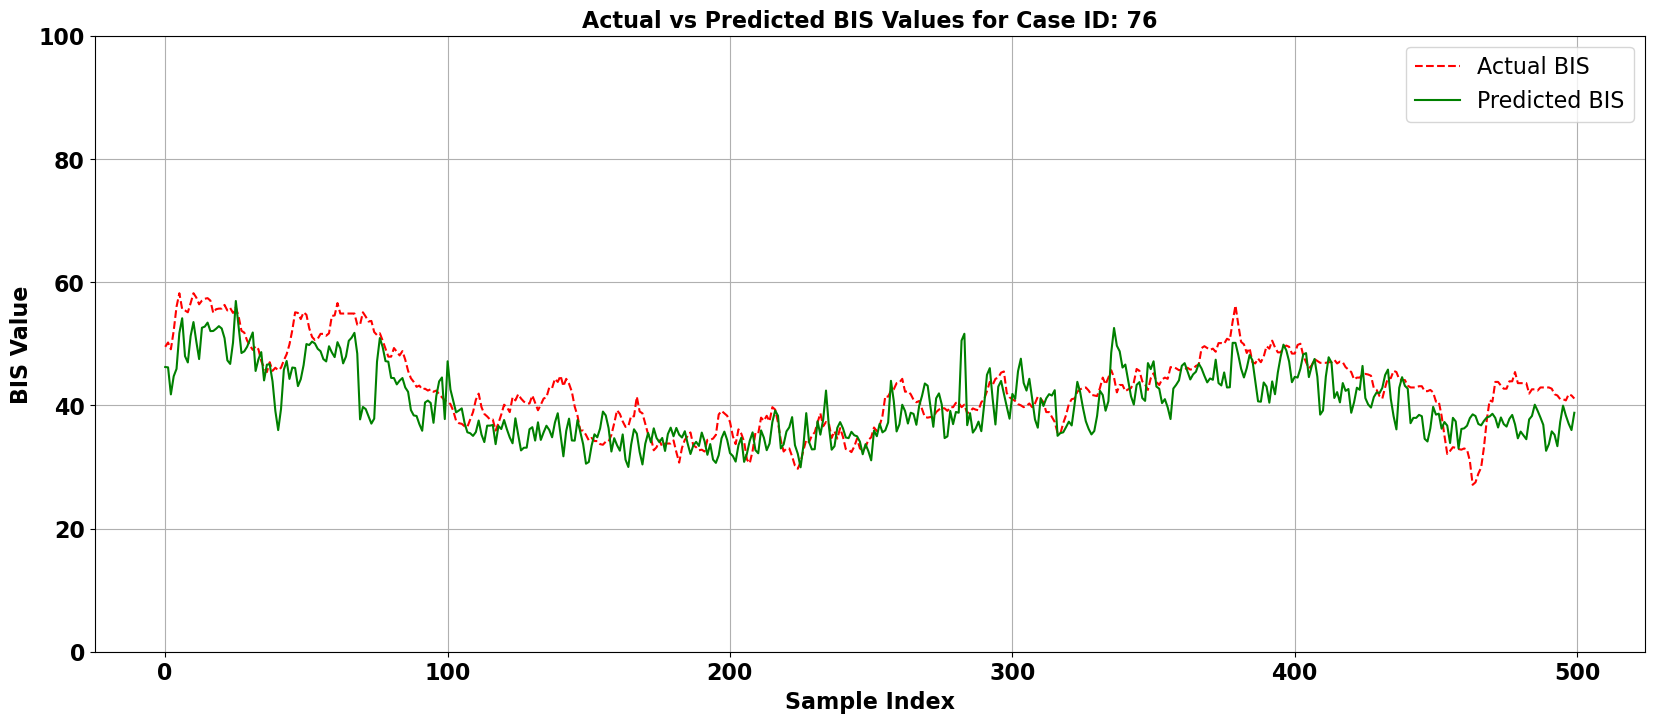

Plot saved to output/EEG_GRU-AvP_plot.png


<Figure size 640x480 with 0 Axes>

In [40]:
results = evaluate_model(model, test_loader, device)
act_vs_pred(10, model)

### Integrated Gradients

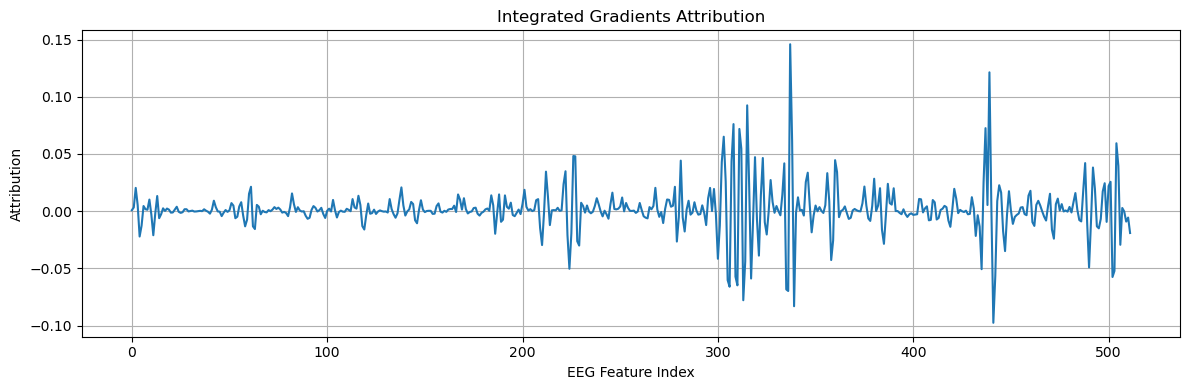

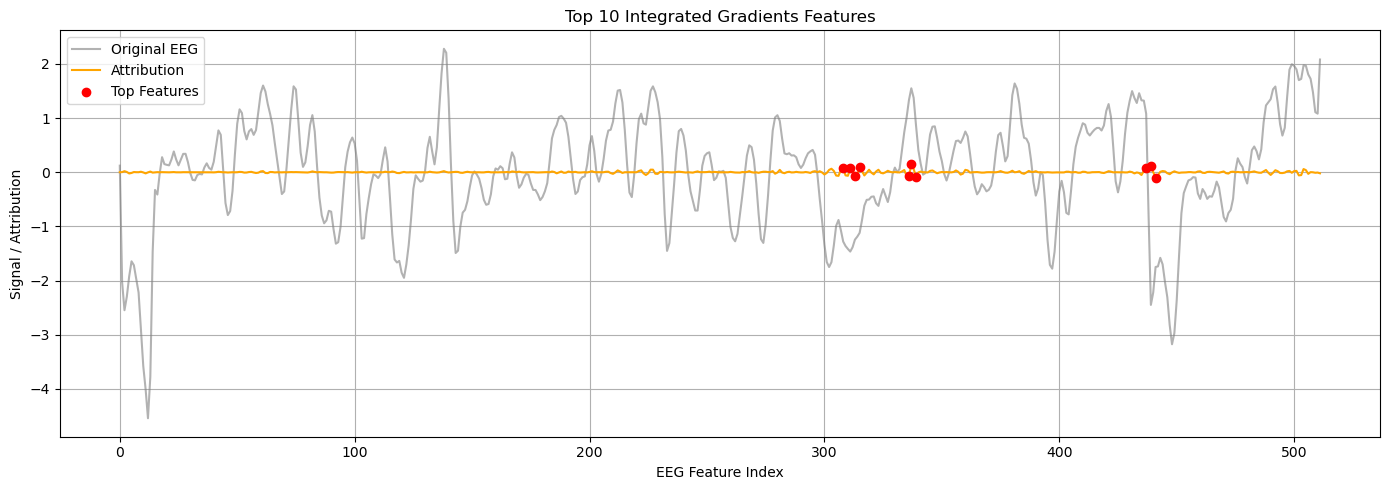

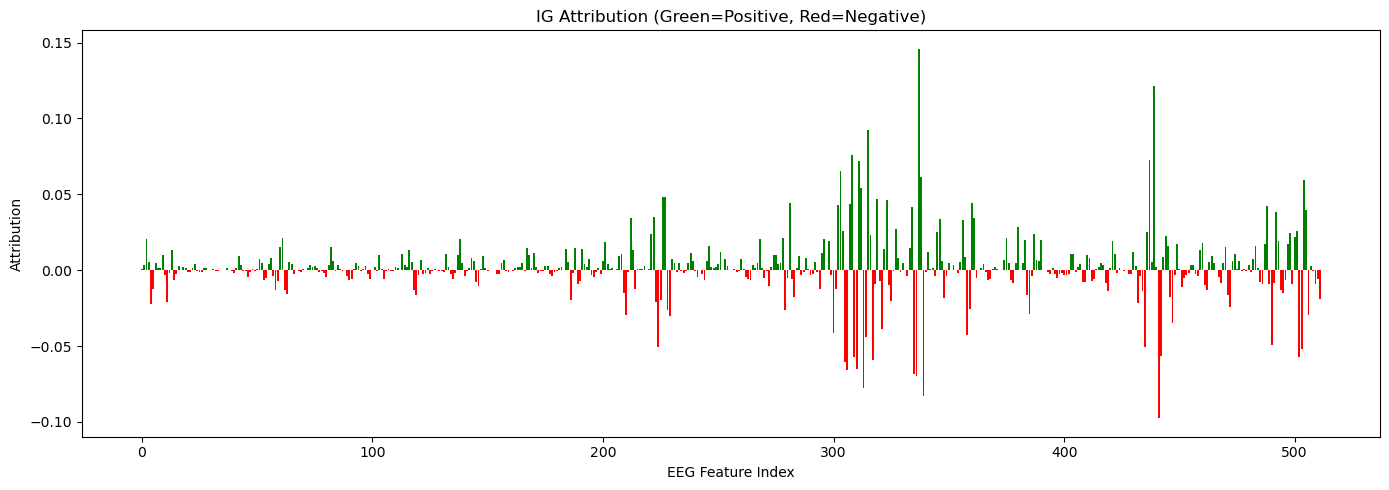

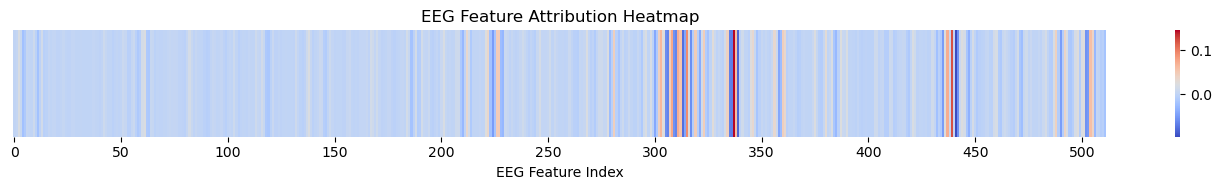

In [41]:
### Integrated Gradients
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        if output.ndim == 0:
            output = output.unsqueeze(0).unsqueeze(0)
        elif output.ndim == 1:
            output = output.unsqueeze(1)
        return output

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # ✅ Required for cuDNN backward in LSTM

# 3. Pick a test sample
X_explain = x_test_tensor[100:101].to(device)  # Shape: (1, 512)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(-1)        # (1, 512, 1)

# 4. Baseline for Integrated Gradients
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Signal / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot (Positive/Negative influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("IG Attribution (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## EEGTransformer

In [42]:

# Transformer Model
class EEGTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim):
        super(EEGTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True  # Input shape: [batch_size, seq_len, feature_dim]
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer(x)  # Input shape: [batch_size, seq_len, feature_dim]
        x = x[:, 0, :]  # Use only the first sequence element (seq_len=1)
        x = self.fc(x)  # Shape: [batch_size, output_dim]
        return x

# Initialize Model
input_dim = x.shape[1]  # Feature size
model = EEGTransformer(input_dim=input_dim, num_heads=4, num_layers=2, hidden_dim=128, output_dim=1).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)



### Training Loop

c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
 20%|██        | 1/5 [02:20<09:21, 140.25s/it]

Epoch 1/5, Training Loss: 0.8849, Testing Loss: 0.9064, LR: 0.000100


 40%|████      | 2/5 [04:42<07:04, 141.63s/it]

Epoch 2/5, Training Loss: 0.8178, Testing Loss: 0.7882, LR: 0.000100


 60%|██████    | 3/5 [07:05<04:44, 142.00s/it]

Epoch 3/5, Training Loss: 0.7935, Testing Loss: 0.7682, LR: 0.000100


 80%|████████  | 4/5 [09:17<02:17, 137.94s/it]

Epoch 4/5, Training Loss: 0.7780, Testing Loss: 0.7656, LR: 0.000100


100%|██████████| 5/5 [10:55<00:00, 131.19s/it]

Epoch 5/5, Training Loss: 0.7679, Testing Loss: 0.7535, LR: 0.000100
Model saved to output/EEGTransformer-transformer_model.pth


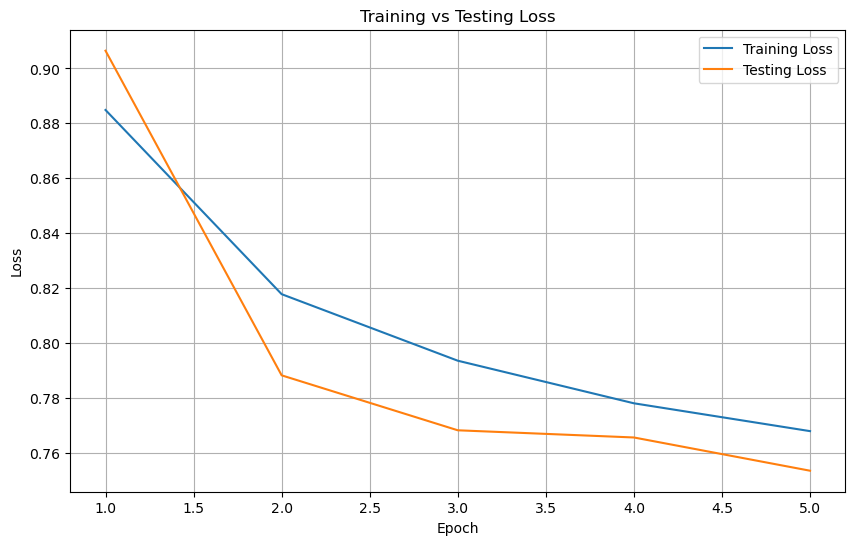

Loss plot saved to output/EEGTransformer-loss_plot.png
Final Training Loss: 0.7679, Final Testing Loss: 0.7535


In [43]:
# Initialize Early Stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# Learning Rate Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Training Loop
num_epochs = 5
train_losses = []
test_losses = []

# Create output directory
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"

with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Transformer expects [batch_size, seq_len, feature_dim]
        batch_x = batch_x.unsqueeze(1)  # Add sequence length dimension

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Evaluate on Test Set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Transformer expects [batch_size, seq_len, feature_dim]
            batch_x = batch_x.unsqueeze(1)  # Add sequence length dimension

            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    # Learning Rate Adjustment
    scheduler.step(test_losses[-1])

    # Save log
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")

    # Print Epoch Stats
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    # Early Stopping Check
    if early_stopping(test_losses[-1]):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the Model
model_path = f"output/{str(model).split('(')[0]}-transformer_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Training vs Testing Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Results
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")


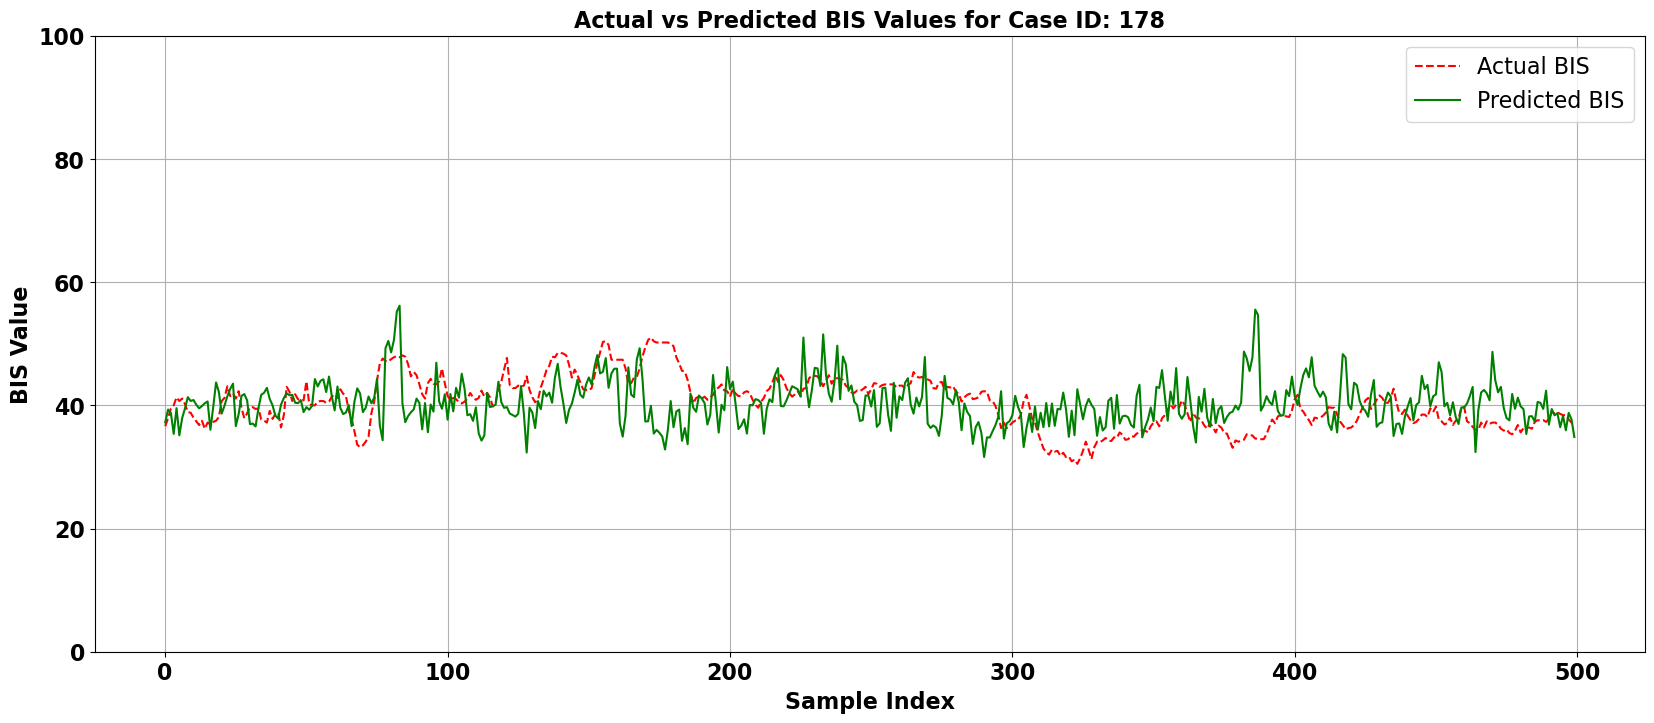

<Figure size 640x480 with 0 Axes>

In [44]:
# Define the act_vs_pred function
def act_vs_pred(index, model):
    # Select a single case ID from test data
    selected_case_id = test_cases[index]  # Choose the case ID at the specified index
    case_mask = (case_ids == selected_case_id) & test_idx  # Mask for the selected case in the test dataset

    x_case = x[case_mask][:500]  # EEG signals for the selected case
    y_case = y_actual_for_plot[case_mask][:500]  # Target values for the selected case

    # Convert to PyTorch tensors
    x_case_tensor = torch.tensor(x_case, dtype=torch.float32).to(device)
    y_case_tensor = torch.tensor(y_case, dtype=torch.float32).to(device)

    # Add sequence dimension for the model
    x_case_tensor = x_case_tensor.unsqueeze(1)  # Shape: [num_samples, 1, feature_dim]

    # Make predictions
    with torch.no_grad():
        predictions = model(x_case_tensor).squeeze().cpu().numpy()  # Predicted BIS values
    actual_values = y_case_tensor.cpu().numpy()  # Actual BIS values

    
    y_pred_case_real = predictions * y_std_data + y_mean_data
    
    # Plot actual vs. predicted BIS values
    plt.figure(figsize=(20, 8))
    plt.plot(actual_values, label="Actual BIS", color="red", linestyle="--")
    plt.plot(y_pred_case_real, label="Predicted BIS", color="green", linestyle="-")

    # Set axis labels with bold font and font size 16
    plt.xlabel("Sample Index", fontsize=16, fontweight='bold')
    plt.ylabel("BIS Value", fontsize=16, fontweight='bold')

    # Set the title with bold font
    plt.title(f"Actual vs Predicted BIS Values for Case ID: {selected_case_id}", fontsize=16, fontweight='bold')

    # Customize ticks to be bold
    plt.xticks(fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')

    # Increase y-axis range by setting the limits
    plt.ylim(0, 100)  # Adjust the range as needed

    # Show legend and grid
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()
    loss_plot_path = f"output/{str(model).split('(')[0]}-AvP_plot.png"
    plt.savefig(loss_plot_path)



act_vs_pred(4, model)

### Function for evaluation metrics

In [45]:

import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import numpy as np

# Updated Function for Evaluation Metrics
def evaluate_model(model, test_loader, y_test, case_ids_test, device, BIS_THRESHOLD=60, output_dir="output"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # File to save evaluation metrics
    eval_file = os.path.join(output_dir, str(model).split("(")[0]+"-evaluation_metrics.txt")
    
    model.eval()
    actuals, predictions, case_ids = [], [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_x = batch_x.unsqueeze(1)  # Add sequence dimension
            output = model(batch_x)
            actuals.extend(batch_y.cpu().numpy())
            predictions.extend(output.squeeze().cpu().numpy())
            case_ids.extend(case_ids_test)  # Collect corresponding case IDs

    actuals = np.array(actuals)
    predictions = np.array(predictions)
    case_ids = np.array(case_ids)

    # Core regression metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # Temporal consistency metrics
    pearson_corr, _ = pearsonr(actuals, predictions)
    cosine_sim = 1 - cosine(actuals, predictions)  # Cosine similarity


    # Prepare evaluation output
    eval_output = (
        "Evaluation Metrics:\n"
        f"Mean Squared Error (MSE): {mse:.4f}\n"
        f"Root Mean Squared Error (RMSE): {rmse:.4f}\n"
        f"Mean Absolute Error (MAE): {mae:.4f}\n"
        f"R-Squared (R^2): {r2:.4f}\n"
        f"Pearson Correlation: {pearson_corr:.4f}\n"
        f"Cosine Similarity: {cosine_sim:.4f}\n"
    )

    # Print metrics
    print(eval_output)

    # Save metrics to a file
    with open(eval_file, "w") as f:
        f.write(eval_output)

    print(f"Evaluation metrics saved to {eval_file}")





evaluate_model(model, test_loader, y_test, case_ids[test_idx], device)

Evaluation Metrics:
Mean Squared Error (MSE): 0.7535
Root Mean Squared Error (RMSE): 0.8680
Mean Absolute Error (MAE): 0.6719
R-Squared (R^2): 0.2466
Pearson Correlation: 0.5096
Cosine Similarity: 0.5325

Evaluation metrics saved to output\EEGTransformer-evaluation_metrics.txt


### Integrated Gradients

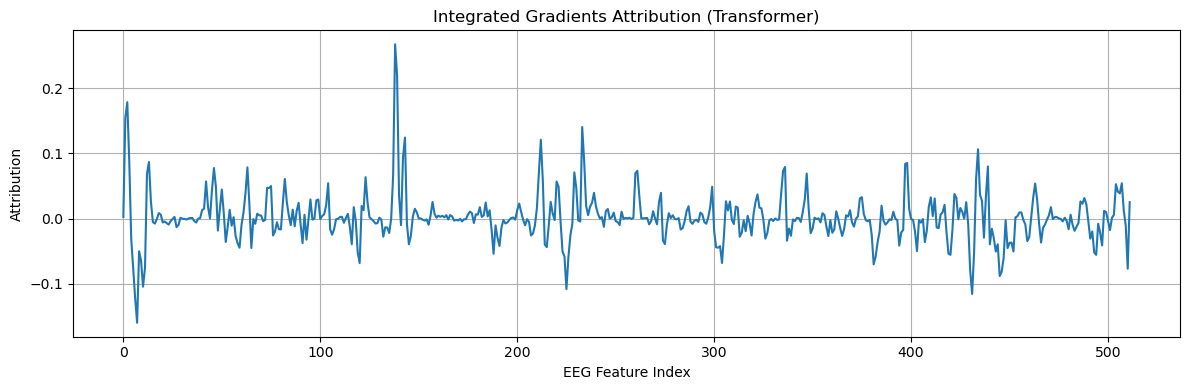

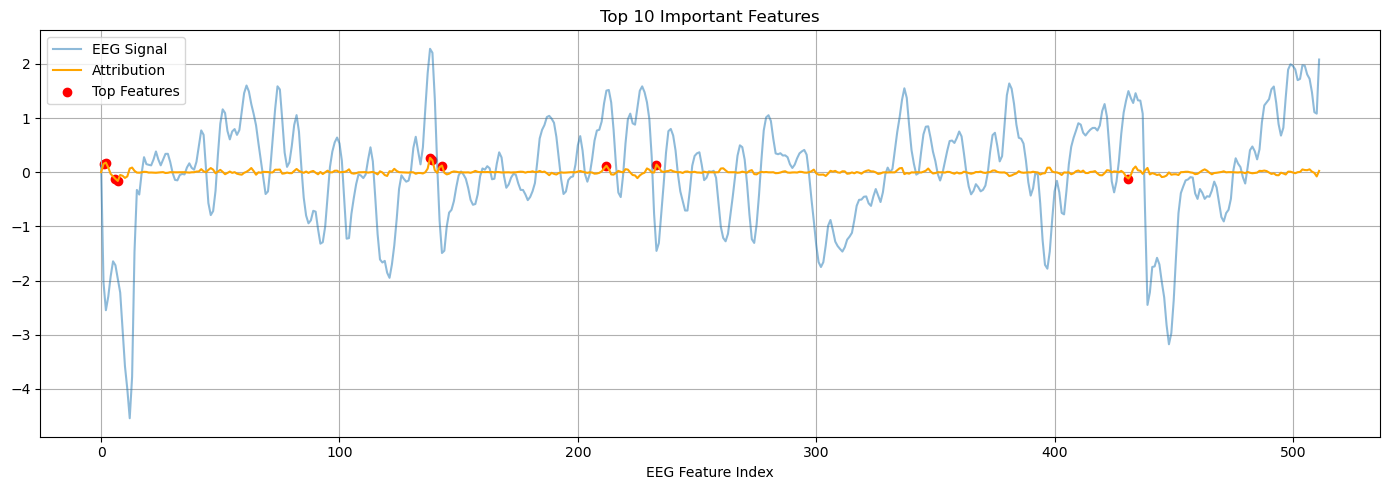

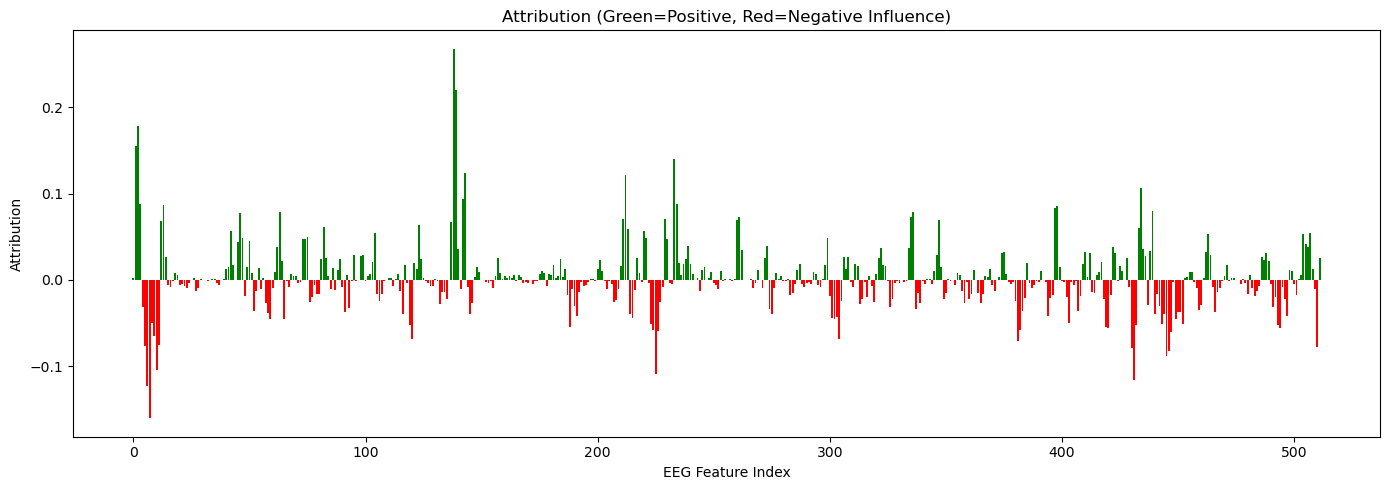

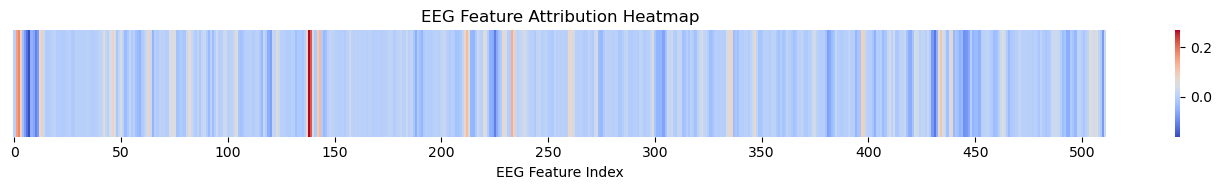

In [46]:
### Integrated Gradients
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrap Transformer to output in correct shape for Captum
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)  # Expected: [batch_size, 1]
        if out.ndim == 0:
            out = out.unsqueeze(0).unsqueeze(0)
        elif out.ndim == 1:
            out = out.unsqueeze(1)
        return out

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.train()  # Required for Transformer gradient flow

# 3. Select a sample from x_test_tensor: shape [1, 512]
X_explain = x_test_tensor[100:101].to(device)  # Shape: [1, 512]

# 4. Reshape to match Transformer: [batch_size, seq_len=1, feature_dim=512]
X_explain = X_explain.unsqueeze(1)  # [1, 1, 512]
baseline = torch.zeros_like(X_explain).to(device)

# 5. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 6. Extract attributions for 512 features
attr_np = attributions.squeeze().detach().cpu().numpy()  # (512,)
eeg_signal = X_explain.squeeze().detach().cpu().numpy()  # (512,)

# 7. Plot Attribution Signal
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution (Transformer)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Top-N Features Overlay
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]
plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="EEG Signal", alpha=0.5)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features")
plt.title(f"Top {top_n} Important Features")
plt.xlabel("EEG Feature Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Colored Bar Plot
colors = ['green' if v > 0 else 'red' for v in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("Attribution (Green=Positive, Red=Negative Influence)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 10. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()


## SignalToSignalTransformer

In [47]:
# Transformer Model Definition
class SignalToSignalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim):
        super(SignalToSignalTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Linear(input_dim, 1)  # Ensure scalar output

    def forward(self, x):
        x = self.transformer(x)  # Shape: [batch_size, seq_len, input_dim]
        x = x.mean(dim=1)  # Mean pooling over sequence length
        x = self.fc(x)  # Output: [batch_size, 1]
        return x.squeeze(-1)  # Remove last dimension for regression [batch_size]



# Initialize Model
input_dim = x_train_tensor.shape[1]  # Feature size
model = SignalToSignalTransformer(input_dim=input_dim, num_heads=4, num_layers=2, hidden_dim=128).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
 20%|██        | 1/5 [01:37<06:30, 97.73s/it]

Epoch 1/5, Training Loss: 0.8828, Testing Loss: 0.8479, LR: 0.000100


 40%|████      | 2/5 [03:03<04:32, 90.72s/it]

Epoch 2/5, Training Loss: 0.8169, Testing Loss: 0.7962, LR: 0.000100


 60%|██████    | 3/5 [04:27<02:54, 87.44s/it]

Epoch 3/5, Training Loss: 0.7947, Testing Loss: 0.7726, LR: 0.000100


 80%|████████  | 4/5 [05:50<01:25, 85.93s/it]

Epoch 4/5, Training Loss: 0.7785, Testing Loss: 0.7841, LR: 0.000100


100%|██████████| 5/5 [07:12<00:00, 86.48s/it]

Epoch 5/5, Training Loss: 0.7679, Testing Loss: 0.7444, LR: 0.000100
Model saved to output/SignalToSignalTransformer-transformer_model.pth


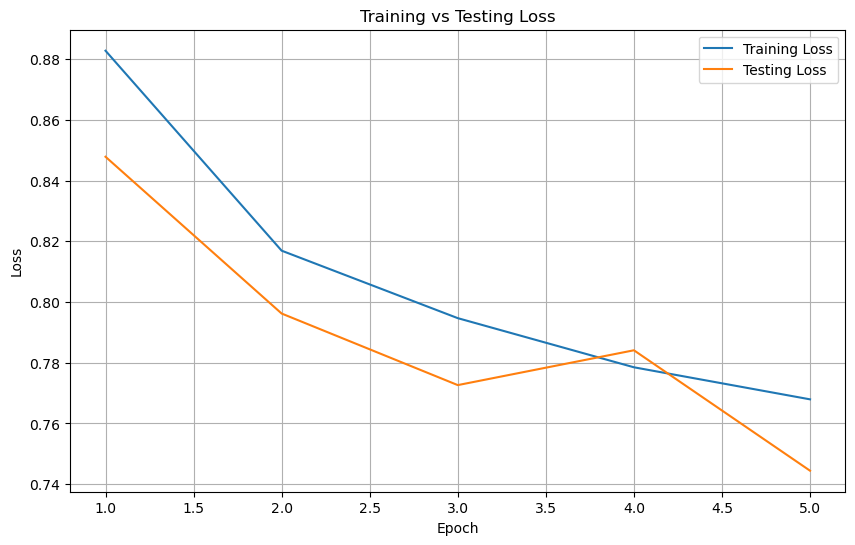

Loss plot saved to output/SignalToSignalTransformer-loss_plot.png
Final Training Loss: 0.7679, Final Testing Loss: 0.7444


In [48]:
# Initialize Early Stopping
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# Learning Rate Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

# Training Loop
num_epochs = 5
train_losses = []
test_losses = []

# Create output directory
os.makedirs("output", exist_ok=True)
log_file = f"output/{str(model).split('(')[0]}-training_log.txt"

with open(log_file, "w") as log:
    log.write("Epoch,Training Loss,Testing Loss,Learning Rate\n")

for epoch in tqdm(range(1, num_epochs + 1)):
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Transformer expects [batch_size, seq_len, feature_dim]
        batch_x = batch_x.unsqueeze(1)  # Add sequence length dimension

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Evaluate on Test Set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Transformer expects [batch_size, seq_len, feature_dim]
            batch_x = batch_x.unsqueeze(1)  # Add sequence length dimension

            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    # Learning Rate Adjustment
    scheduler.step(test_losses[-1])

    # Save log
    current_lr = optimizer.param_groups[0]["lr"]
    with open(log_file, "a") as log:
        log.write(f"{epoch},{train_losses[-1]:.4f},{test_losses[-1]:.4f},{current_lr:.6f}\n")

    # Print Epoch Stats
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Testing Loss: {test_losses[-1]:.4f}, LR: {current_lr:.6f}")

    # Early Stopping Check
    if early_stopping(test_losses[-1]):
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the Model
model_path = f"output/{str(model).split('(')[0]}-transformer_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plot Training vs Testing Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Testing Loss")
plt.legend()
plt.grid(True)
loss_plot_path = f"output/{str(model).split('(')[0]}-loss_plot.png"
plt.savefig(loss_plot_path)
plt.show()
print(f"Loss plot saved to {loss_plot_path}")

# Final Results
print(f"Final Training Loss: {train_losses[-1]:.4f}, Final Testing Loss: {test_losses[-1]:.4f}")

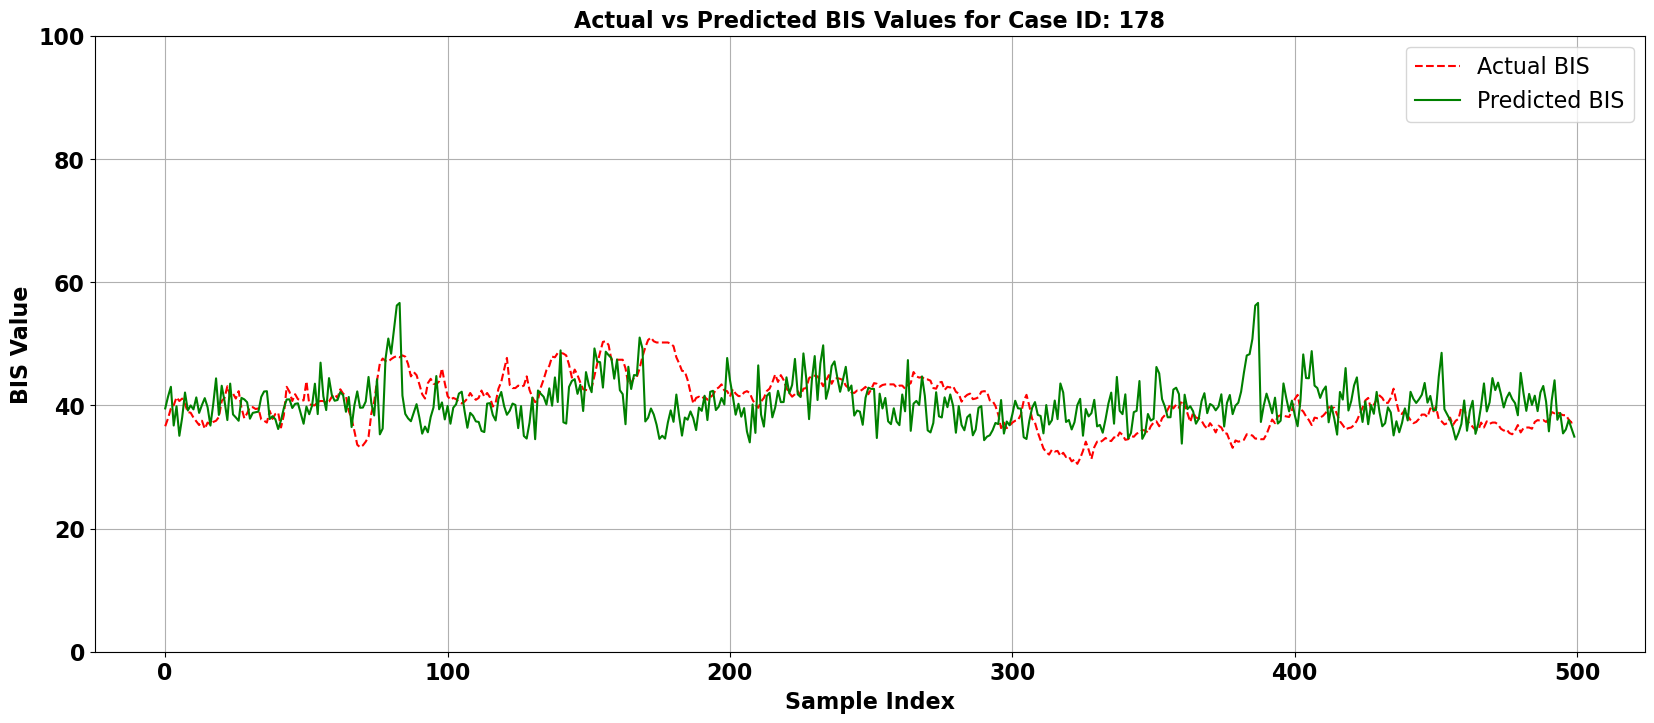

<Figure size 640x480 with 0 Axes>

In [49]:
act_vs_pred(4, model)

In [50]:

import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import numpy as np

# Updated Function for Evaluation Metrics
def evaluate_model(model, test_loader, y_test, case_ids_test, device, BIS_THRESHOLD=60, output_dir="output"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # File to save evaluation metrics
    eval_file = os.path.join(output_dir, str(model).split("(")[0]+"-evaluation_metrics.txt")
    
    model.eval()
    actuals, predictions, case_ids = [], [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_x = batch_x.unsqueeze(1)  # Add sequence dimension
            output = model(batch_x)
            actuals.extend(batch_y.cpu().numpy())
            predictions.extend(output.squeeze().cpu().numpy())
            case_ids.extend(case_ids_test)  # Collect corresponding case IDs

    actuals = np.array(actuals)
    predictions = np.array(predictions)
    case_ids = np.array(case_ids)

    # Core regression metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # Temporal consistency metrics
    pearson_corr, _ = pearsonr(actuals, predictions)
    cosine_sim = 1 - cosine(actuals, predictions)  # Cosine similarity


    # Prepare evaluation output
    eval_output = (
        "Evaluation Metrics:\n"
        f"Mean Squared Error (MSE): {mse:.4f}\n"
        f"Root Mean Squared Error (RMSE): {rmse:.4f}\n"
        f"Mean Absolute Error (MAE): {mae:.4f}\n"
        f"R-Squared (R^2): {r2:.4f}\n"
        f"Pearson Correlation: {pearson_corr:.4f}\n"
        f"Cosine Similarity: {cosine_sim:.4f}\n"
    )

    # Print metrics
    print(eval_output)

    # Save metrics to a file
    with open(eval_file, "w") as f:
        f.write(eval_output)

    print(f"Evaluation metrics saved to {eval_file}")





evaluate_model(model, test_loader, y_test, case_ids[test_idx], device)

Evaluation Metrics:
Mean Squared Error (MSE): 0.7444
Root Mean Squared Error (RMSE): 0.8628
Mean Absolute Error (MAE): 0.6669
R-Squared (R^2): 0.2556
Pearson Correlation: 0.5143
Cosine Similarity: 0.5378

Evaluation metrics saved to output\SignalToSignalTransformer-evaluation_metrics.txt


### Integrated Gradients

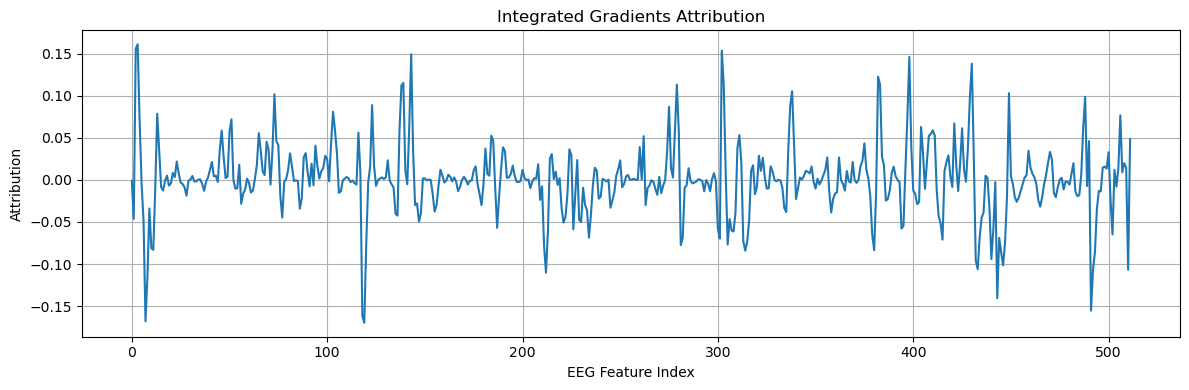

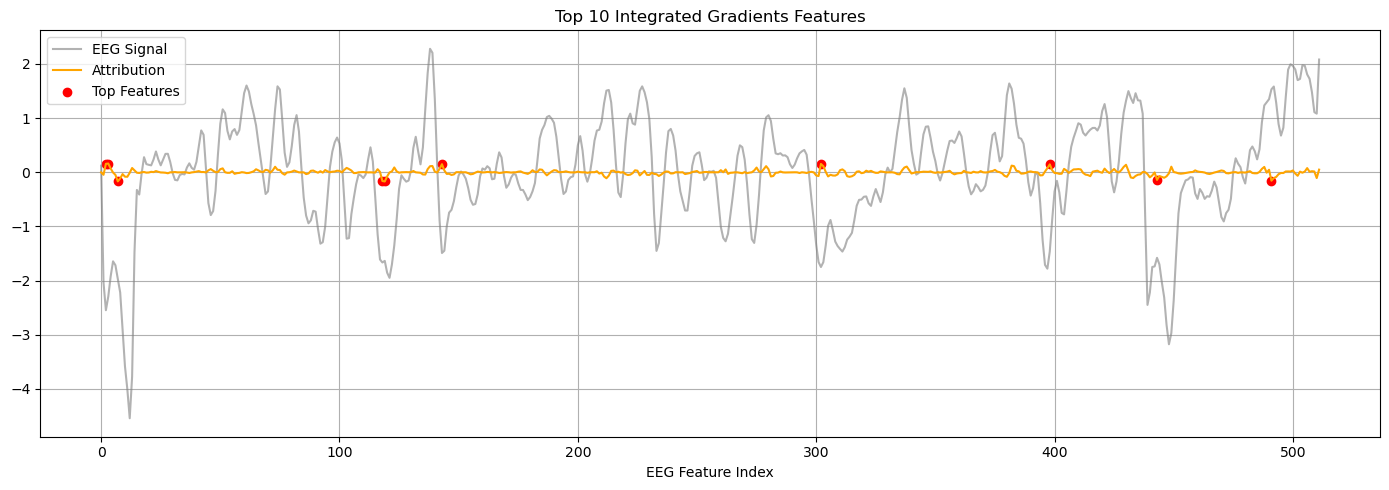

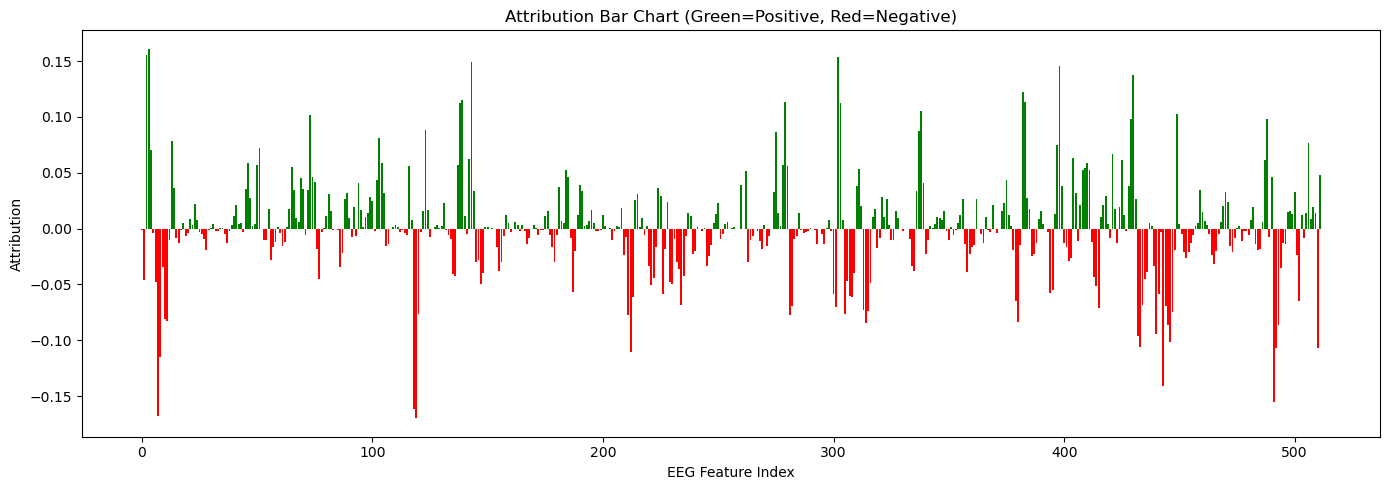

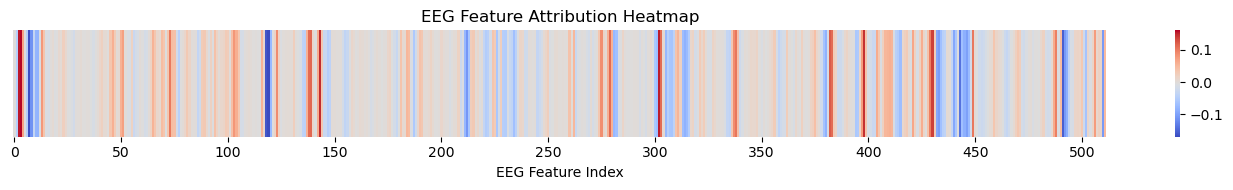

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients

# 1. Wrapper to ensure Captum receives the correct shape
class CaptumWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        if out.ndim == 0:
            out = out.unsqueeze(0).unsqueeze(0)
        elif out.ndim == 1:
            out = out.unsqueeze(1)
        return out

# 2. Wrap and move to device
wrapped_model = CaptumWrapper(model).to(device)
wrapped_model.eval()

# 3. Pick test sample and reshape
X_explain = x_test_tensor[100:101].to(device)  # Shape: [1, 512]
X_explain = X_explain.unsqueeze(1)             # ✅ Shape: [1, 1, 512]
baseline = torch.zeros_like(X_explain).to(device)

# 4. Run Integrated Gradients
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    return_convergence_delta=True
)

# 5. Process attribution results
attr_np = attributions.squeeze().detach().cpu().numpy()  # (512,)
eeg_signal = X_explain.squeeze().detach().cpu().numpy()  # (512,)

# 6. Plot Attribution Curve
plt.figure(figsize=(12, 4))
plt.plot(attr_np)
plt.title("Integrated Gradients Attribution")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Top-N features
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="EEG Signal", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Features")
plt.title(f"Top {top_n} Integrated Gradients Features")
plt.xlabel("EEG Feature Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Bar Plot of Influence
colors = ['green' if v > 0 else 'red' for v in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("Attribution Bar Chart (Green=Positive, Red=Negative)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# 9. Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()
